# 1. Introduction

On commence par importer toutes les bibliothèques nécessaires pour la suite du projet. Elles permettront de manipuler des données, de traiter des images, mais aussi de construire nos modèles de prédictions.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.cluster import KMeans
import geopandas as gpd
from shapely.geometry import Point
from sklearn.neighbors import KNeighborsClassifier
import os
from PIL import Image
import cv2
import skimage.measure
import osmnx as ox
import time
from geopy.distance import geodesic
from sklearn.neighbors import BallTree
import unidecode
from unidecode import unidecode
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import make_scorer, mean_absolute_percentage_error

On va ensuite lire les fichiers CSV contenant les jeux de données d'entraînement et de test, ainsi que les valeurs cibles (y_train). On extrait certaines colonnes utiles comme les identifiants (id_annonce) et les noms de villes (city) pour un traitement ultérieur.

In [ ]:
x_train = pd.read_csv("/Users/ayrtondossantos/Desktop/STATISTICAL LEARNING/PROJET/X_train_J01Z4CN.csv")
x_test = pd.read_csv("/Users/ayrtondossantos/Desktop/STATISTICAL LEARNING/PROJET/X_test_BEhvxAN.csv")
y_train = pd.read_csv("/Users/ayrtondossantos/Desktop/STATISTICAL LEARNING/PROJET/y_train_OXxrJt1.csv")

id_annonces_train = x_train['id_annonce'].values
id_annonces_test = x_test['id_annonce'].values

city_train = x_train['city'].values#pour plus tard sur l'ajout de données par raport à la population
city_test = x_test['city'].values

X_train_0=x_train.drop(columns="id_annonce")
Y_train_0=y_train.drop(columns="id_annonce")
X_test_0=x_test.drop(columns="id_annonce")


# 2. Prétraitement des données tabulaires

Dans cette cellule, nous fusionnons nos jeux de données x_train et y_train à l’aide de la colonne commune id_annonce, afin d’obtenir un seul DataFrame contenant à la fois les features et la variable cible. Nous vérifions ensuite les dimensions du DataFrame résultant ainsi qu’un aperçu des premières lignes pour nous assurer que la fusion s’est bien déroulée.

In [ ]:
df = pd.merge(x_train, y_train, on ="id_annonce")
print(df.shape)#on verifie les dimensions après la fusion
print(df.head())#on a un aperçu des premières lignes

(37368, 28)
   id_annonce property_type  approximate_latitude  approximate_longitude  \
0    35996577   appartement             43.643880               7.117183   
1    35811033   appartement             45.695757               4.895610   
2    35731841        maison             47.966791              -1.220451   
3    35886765        maison             47.289292              -1.878805   
4    35781137   appartement             45.718992               4.844234   

                city  postal_code   size  floor  land_size  \
0  villeneuve-loubet         6270   63.0    NaN        NaN   
1         venissieux        69200   90.0    3.0        NaN   
2           moutiers        35130   61.0    NaN      370.0   
3          cordemais        44360  142.0    NaN      764.0   
4          lyon-7eme        69007   88.0    3.0        NaN   

   energy_performance_value  ... nb_boxes  nb_photos has_a_balcony  \
0                       NaN  ...      0.0        4.0           0.0   
1                 

On modifie les options d'affichage de pandas pour que les nombres réels soient affichés avec deux chiffres après la virgule, ce qui rend les résultats plus lisibles. Cela permet aussi d’éviter la notation scientifique qui peut apparaître pour certaines colonnes.

In [ ]:
pd.set_option("display.float_format","{:,.2f}".format)#on veut afficher les nombres réel avec 2 chiffres après la virgule
#sinon on a la notation scientifique pour certaines colonnes
df.describe()

,id_annonce,approximate_latitude,approximate_longitude,postal_code,size,floor,land_size,energy_performance_value,ghg_value,nb_rooms,...,nb_boxes,nb_photos,has_a_balcony,nb_terraces,has_a_cellar,has_a_garage,has_air_conditioning,last_floor,upper_floors,price
count,"37,368.00","37,368.00","37,368.00","37,368.00","36,856.00","9,743.00","15,581.00","19,068.00","18,530.00","35,802.00",...,"37,368.00","37,368.00","37,368.00","37,368.00","37,368.00","37,368.00","37,368.00","37,368.00","37,368.00","37,368.00"
mean,"35,690,331.78",46.55,2.62,"53,598.37","1,088.83",3.48,"3,995.67",205.39,31.85,4.25,...,0.18,7.98,0.15,0.31,0.20,0.05,0.04,0.00,0.00,"343,221.27"
std,"1,468,073.31",2.36,2.60,"28,807.22","5,555.32",6.73,"54,415.95",790.50,310.58,2.99,...,0.38,4.65,0.36,0.46,0.40,0.23,0.20,0.06,0.02,"308,912.91"
min,"6,774,630.00",41.37,-4.73,"1,000.00",1.00,1.00,1.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"24,465.00"
25%,"35,808,248.50",43.92,1.10,"30,150.00",74.00,1.00,362.00,125.00,8.00,3.00,...,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"155,462.50"
50%,"35,870,964.00",46.94,2.38,"59,000.00",115.00,2.00,795.00,180.00,16.00,4.00,...,0.00,8.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"255,250.00"
75%,"36,011,187.00",48.84,4.62,"78,210.00",235.25,4.00,"1,841.00",239.00,36.00,5.00,...,0.00,10.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,"415,000.00"
max,"36,098,807.00",51.08,9.50,"95,880.00","411,311.00",55.00,"6,203,700.00","100,000.00","17,024.00",130.00,...,1.00,50.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,"2,299,000.00"


Nous créons ici un seul DataFrame data_complet en regroupant les données d'entraînement (df) et de test (x_test). Cela nous permet de prétraiter l’ensemble des données en une seule fois, de manière cohérente. Nous vérifions ensuite les dimensions et un aperçu des premières lignes pour s'assurer que tout s'est bien passé. Enfin, nous faisons une copie de ce DataFrame (data_complet2) que nous pourrons réutiliser plus tard, notamment pour l’imputation des valeurs manquantes avec l’Iterative Imputer (autre méthode).

In [ ]:
#on crée un data avec toutes les données, mêmes celles de test car on va preprocess nos données
data_complet = pd.concat([df, x_test]).reset_index(drop=True)
print(data_complet.shape)#on verifie les dimensions après la fusion
print(data_complet.head())#on a un aperçu des premières lignes

data_complet2 = data_complet.copy() #on fait la copie pour pouvoir s'en resservir dans l'iterative imputer à la fin

(46707, 28)
   id_annonce property_type  approximate_latitude  approximate_longitude  \
0    35996577   appartement                 43.64                   7.12   
1    35811033   appartement                 45.70                   4.90   
2    35731841        maison                 47.97                  -1.22   
3    35886765        maison                 47.29                  -1.88   
4    35781137   appartement                 45.72                   4.84   

                city  postal_code   size  floor  land_size  \
0  villeneuve-loubet         6270  63.00    NaN        NaN   
1         venissieux        69200  90.00   3.00        NaN   
2           moutiers        35130  61.00    NaN     370.00   
3          cordemais        44360 142.00    NaN     764.00   
4          lyon-7eme        69007  88.00   3.00        NaN   

   energy_performance_value  ... nb_boxes  nb_photos has_a_balcony  \
0                       NaN  ...     0.00       4.00          0.00   
1                 

Nous vérifions le nombre de valeurs manquantes dans la colonne price, qui est notre variable cible. Ensuite, nous affichons le nombre de lignes dans x_test. Cela nous permet de confirmer que toutes les valeurs manquantes de la colonne price correspondent bien aux logements présents dans le jeu de test, ce qui est logique puisque ce jeu ne contient pas les prix à prédire.

In [ ]:
#on vérifie le nombre de valeurs manquantes dans la colonne price
print(data_complet['price'].isna().sum())
print(len(x_test))

#on vérifie donc bien que dans la colonne price, toutes les valeurs Nan sont celles des logements de x_test

9339
9339


On va ensuite sélectionner uniquement les variables numériques du DataFrame data_complet, en excluant les colonnes id_annonce et postal_code, qui n’ont pas de signification statistique pour une analyse de corrélation.
Nous calculons ensuite la corrélation de chaque variable avec le prix (price), en retirant le prix lui-même pour éviter une corrélation triviale égale à 1.
Enfin, nous visualisons ces corrélations à l’aide d’un barplot, ce qui nous permet d’identifier quelles variables numériques sont les plus liées linéairement au prix des logements.

In [ ]:
col_num =data_complet.select_dtypes(include=["int","float"]).drop(columns=["id_annonce", "postal_code"])
#on retire seulement les colonnes code postal, identifiant en plus
#ce sont des colonnes à valeurs numériques mais qui n'ont pas de sens pour un calcul de corrélation avec le prix
correlations = col_num.corr()["price"].drop("price").sort_values(ascending=False)
#on enlève le prix car sinon on calculerait la corrélation entre le prix et lui-même qui vaudrait forcément 1...

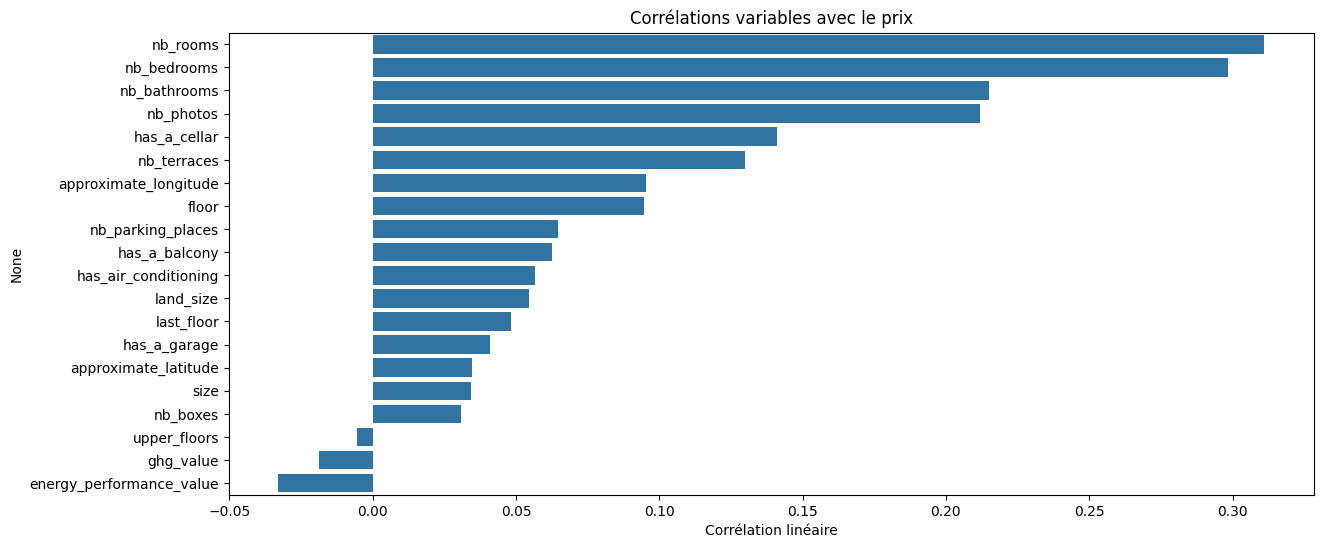

In [ ]:
#on affiche un barplot qui représente les corrélations

plt.figure(figsize=(14, 6))
sb.barplot(x=correlations.values, y=correlations.index)
plt.title("Corrélations variables avec le prix")
plt.xlabel("Corrélation linéaire")
plt.show()

#la corrélation avec id_annonce n'a pas de sens, on ne la prend pas en compte

On supprime ici les colonnes upper_floors et postal_code. La variable upper_floors a peu d’influence sur le prix d’après notre analyse précédente, et le code postal n’apporte pas d’information pertinente ici, on va uniquement se servir de la colonne ville dans la suite.

In [ ]:
data_complet = data_complet.drop(['upper_floors','postal_code'],axis=1) #on retire upper_floors car pas beaucoup d'influence et aussi le code postal

In [ ]:
data_complet.columns

Index(['id_annonce', 'property_type', 'approximate_latitude',
       'approximate_longitude', 'city', 'size', 'floor', 'land_size',
       'energy_performance_value', 'energy_performance_category', 'ghg_value',
       'ghg_category', 'exposition', 'nb_rooms', 'nb_bedrooms', 'nb_bathrooms',
       'nb_parking_places', 'nb_boxes', 'nb_photos', 'has_a_balcony',
       'nb_terraces', 'has_a_cellar', 'has_a_garage', 'has_air_conditioning',
       'last_floor', 'price'],
      dtype='object')

On va ensuite se pencher sur le cas des valeurs manquantes et du traitement de ces données. Pour cela, nous retirons d’abord la colonne price, car elle contient évidemment les valeurs manquantes dans le jeu de test. Puis on affiche un barplot pour visualiser quelles colonnes contiennent des données manquantes ainsi que le nombre de valeurs manquantes.

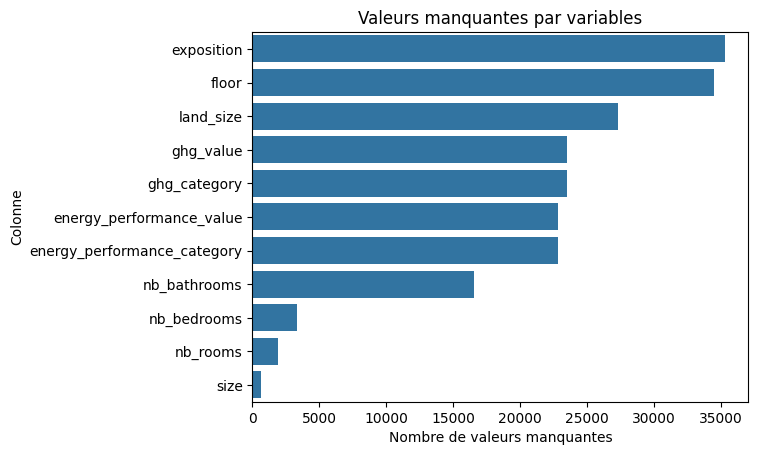

In [ ]:
missing_ = data_complet.drop(['price'],axis=1)
missing = missing_.isna().sum() #compteur pour les valeurs manquantes
missing = missing[missing>0].sort_values(ascending=False)#on récupère les colonnes avec au moins une valeur manquante

sb.barplot(x=missing.values, y=missing.index)
plt.title("Valeurs manquantes par variables")
plt.xlabel("Nombre de valeurs manquantes")
plt.ylabel("Colonne")
plt.show()

On traite ici les valeurs manquantes au cas par cas pour chaque feature. Pour energy_performance_value et ghg_value, on remplaçe les valeurs manquantes par la médiane de chaque colonne (on préfère la médiane à la moyenne pour éviter les biais et l'impact des valeurs extrêmes). On fait la même chose pour les colonnes nb_rooms, nb_bedrooms, nb_bathrooms et size en remplaçant chaque NaN par la médiane de la colonne correspondante. On choisit de supprimer les colonnes energy_performance_category et ghg_category car elles sont redondantes et plus difficiles à traiter (variables catégorielles)

In [ ]:
data_complet["floor"]= data_complet["floor"].fillna(0)#on remplace les éventuels NaN restants par 0 car cela représente pour la majorité des maisons donc elles ne sont pas situés au premier ou 2e étage par exemple

In [ ]:
data_complet["land_size"]= data_complet["land_size"].fillna(0)#on remplace les NaN par 0 car cela représente souvent les appartements

In [ ]:
data_complet["size"]= data_complet["size"].fillna(data_complet["size"].median())#on remplace les NaN par 0

In [ ]:
data_complet["energy_performance_value"]= data_complet["energy_performance_value"].fillna(data_complet["energy_performance_value"].median())#on remplace les NaN par 0
data_complet["ghg_value"]= data_complet["ghg_value"].fillna(data_complet["ghg_value"].median())#on remplace les NaN par 0
data_complet = data_complet.drop(["energy_performance_category", "ghg_category"],axis=1)

In [ ]:
for k in ["nb_rooms", "nb_bedrooms", "nb_bathrooms"]:
    data_complet[k] = data_complet[k].fillna(data_complet[k].median()) #on impute la médiane pour les valeurs manquantes

Ici nous remplaçons les valeurs manquantes de la colonne exposition par la chaîne de caractères "inconnue". Cela permet de conserver l'information sous forme catégorielle sans perdre de lignes.

In [ ]:
data_complet["exposition"]= data_complet["exposition"].fillna("inconnue")

On va ensuite essayer de comprendre un peu mieux l'influence du type de propriété sur le prix. On affiche un barplot représentant le prix moyen en fonction du type de bien immobilier (property_type). À travers ce graphique on va essayer d’identifier les écarts de prix entre les différents types de logements (maisons, appartements, studios, etc.) et d’évaluer l’influence du type de bien sur le prix, ce qui est précieux pour la modélisation. On préfère mettre une échelle logarithmique sur l’axe des ordonnées pour mieux visualiser les écarts importants de prix et que le graphique soit plus lisible.

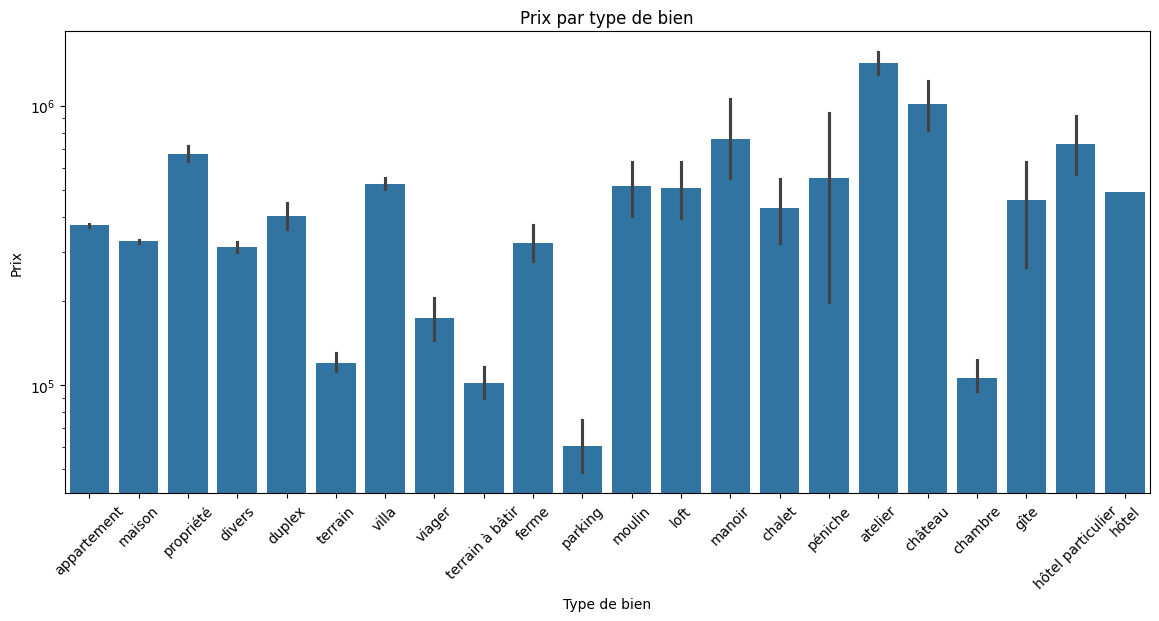

In [ ]:
plt.figure(figsize=(14, 6))
sb.barplot(data=data_complet, x= "property_type", y=data_complet["price"])
plt.title("Prix par type de bien")
plt.xticks(rotation=45)
plt.yscale("log")#échelle logarithmique
plt.xlabel("Type de bien")
plt.ylabel("Prix")
plt.show()

On relève une grande diversité de types de biens, avec des prix très différents. Par exemple, les châteaux ou hôtels particuliers coûtent beaucoup plus cher que des biens comme les parkings ou studios. Cela vient donc confirmer l'idée initiale que le type de bien joue donc un rôle important dans le prix.

Ici on traville sur la colonne 'city', on crée une feature city_freq_encode qui encode chaque ville en fonction de sa fréquence d’apparition dans le dataset. Les modèles de prédictions ne peuvent pas exploiter directement des données sous forme de texte comme les noms de villes. Aussi, en utilisant la fréquence d’apparition permet de remplacer une variable catégorielle par une variable numérique tout en conservant une information sur la répartition des données. Cela évite d’avoir trop de variables après encodage donc plus facile à utiliser et moins coûteux.

In [ ]:
#on calcule la fréquence d'apparition de chaque ville
fq = data_complet.groupby('city').size() / len(data_complet)

# on crée la colonne city_freq_encode
data_complet['city_freq_encode'] = data_complet['city'].map(fq)

In [ ]:
data_complet.columns

Index(['id_annonce', 'property_type', 'approximate_latitude',
       'approximate_longitude', 'city', 'size', 'floor', 'land_size',
       'energy_performance_value', 'ghg_value', 'exposition', 'nb_rooms',
       'nb_bedrooms', 'nb_bathrooms', 'nb_parking_places', 'nb_boxes',
       'nb_photos', 'has_a_balcony', 'nb_terraces', 'has_a_cellar',
       'has_a_garage', 'has_air_conditioning', 'last_floor', 'price',
       'city_freq_encode'],
      dtype='object')

Pour la même raison que précédemment, notre modèle de prédiction ne pourra pas interpréter les valeurs texte. On réaliser un encodage one-hot aux variables catégorielles property_type et exposition. On va ainsi créer une nouvelle colonne pour chaque type de valeur (valeur unique) de ces variables, contenant 1 si l’observation correspond à cette modalité, et 0 sinon. Nous mettonsdrop_first=True pour éviter la redondance en supprimant un valeur de référence dans chaque variable. On affiche quelques résultats pour vérifier.

In [ ]:
col = ["property_type","exposition"]
data_complet = pd.get_dummies(data_complet, columns =col, drop_first=True)#on supprime une colonne de référence avec drop_first
#on regarde le résultat pour la variable "exposition" :
print(data_complet.filter(like="exposition_").head(10))

   exposition_Est-Ouest  exposition_Nord  exposition_Nord-Est  \
0                 False            False                False   
1                 False            False                False   
2                 False            False                False   
3                 False            False                False   
4                 False            False                False   
5                 False            False                False   
6                 False            False                False   
7                 False            False                False   
8                 False            False                False   
9                 False            False                False   

   exposition_Nord-Ouest  exposition_Nord-Sud  exposition_Ouest  \
0                  False                False             False   
1                  False                False             False   
2                  False                False             False   
3               

# 3. Création de nouvelles variables

On affiche l’histogramme de la variable price afin d’étudier un peu mieux la manière dont elle se répartie. On ajoute la courbe KDE juste pour avoir une meilleure tendance de la répartition de la variable prix. On tente ici d'identifier la répartition des prix mais surtout de repérer la présence de valeurs extrêmes.


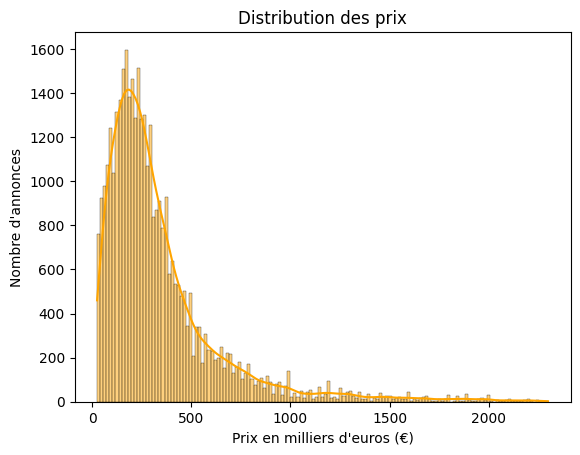

In [ ]:
sb.histplot(data_complet["price"]/1000, kde =True, color ="orange")
plt.title("Distribution des prix")
plt.xlabel("Prix en milliers d'euros (€)")
plt.ylabel("Nombre d'annonces")
plt.show()

On voit que la courbe est fortement asymétrique à droite, signifiant que la majorité des biens ont un prix relativement bas par rapport à un petit nombre dont la valeur s'envole.Le pic principal se situe ici entre 100k € et 400k €, c'est donc dans cette fourchette de prix que l'on retrouve la majorité des biens. Cette asymétrie peut mener à des erreurs dans les modèles linaires, la régression linaire peut être biaisée. Les valeurs très élevées de certains biens peuvent écraser les prédictions des biens modestes si on les corrige pas. On crée donc une nouvelle colonne où l'on applique une transformation logarithmique sur price pour réduire l'influence des biens les plus chers tout en stabilisant la variance.

In [ ]:
data_complet['log_price']=np.log1p(data_complet['price']) #log(1+p) évite log(0) pour des valeurs proches de zéro, on met en log pour réduire la variance et que le modèle apprenne mieux

Ici, on applique la même transformation pour la surface car on a  des valeurs extrêmes qui sont probablement des erreurs de saisie avec un min de 1 m2 et un max de 411 311 m2.

In [ ]:
data_complet['log_size']=np.log1p(data_complet['size'])

Il pourrait ensuite s'avérer intéressant de créer des features croisées, ce sont des nouvelles variables obtenue en combinant deux variables déjà existantes. Cela va nous permettre de créer des interactions pertinentes et prendre ne compte le contexte particulier de l'immobilier. Nous calculons la densité de pièces en divisant le nombre de pièces (nb_rooms) par la surface du logement (size). Cela nous donne une idée de l'espace moyen par pièce, ce qui peut nous indiquer le bien est plutôt spacieux ou à l'inverse très cloisonné. Aussi, nous savons aussi qu'un extérieur apporte de la valeur à un bien on va donc créer une variable outdoor_score qui reflète un niveau de confort extérieur en additionnant les éléments extérieur (1 point pour un balcon/une terrasse). On crée une dernière feature en additionnant la surface habitable en log (log_size) avec la taille du terrain (land_size) pour avoir une mesure plus complète de la taille totale disponible.

In [ ]:
# indice pour la densité de pièces, on calcule le nombre de pièces par m2
data_complet["room_density"] = data_complet["nb_rooms"] / data_complet["size"]

# on compte le nombre d'espace extérieurs : balcon + nb_terraces
data_complet["outdoor_score"] = data_complet["has_a_balcony"].fillna(0).astype(int) + data_complet["nb_terraces"].fillna(0).astype(int)

data_complet['TotalSize'] = data_complet['log_size']+data_complet['land_size']

Nous décidons ici de normaliser certaines variables continues à l’aide du RobustScaler de scikit-learn. On sélectionne les variables que l'on souhaite transformer puis on affiche les statistiques descriptives avant transformation. On applique le
RobustScaler.  Contrairement à un standard scaler classique, le RobustScaler utilise la médiane et l’écart interquartile, ce qui le rend moins sensible aux valeurs extrêmes. On vérifie que les variables ont bien été recentrées et que leur échelle est désormais comparable.

In [ ]:
colonnes_a_scaler = [
    'land_size',
    'log_size',
    'TotalSize',
] #on récupère les colonnes à normaliser

In [ ]:
#on affiche les statistiques descriptives de chaque variable concernée avant standardisation
data_complet[colonnes_a_scaler].describe()

,land_size,log_size,TotalSize
count,"46,707.00","46,707.00","46,707.00"
mean,"1,645.42",5.21,"1,650.63"
std,"32,293.84",1.49,"32,293.86"
min,0.00,0.69,0.69
25%,0.00,4.33,4.39
50%,0.00,4.75,7.55
75%,592.00,5.44,597.35
max,"6,203,700.00",12.93,"6,203,704.51"


In [ ]:
scaler = RobustScaler()
data_complet[colonnes_a_scaler]=scaler.fit_transform(data_complet[colonnes_a_scaler])
data_complet[colonnes_a_scaler].describe()

,land_size,log_size,TotalSize
count,"46,707.00","46,707.00","46,707.00"
mean,2.78,0.41,2.77
std,54.55,1.34,54.46
min,0.00,-3.65,-0.01
25%,0.00,-0.38,-0.01
50%,0.00,0.00,0.00
75%,1.00,0.62,0.99
max,"10,479.22",7.35,"10,462.25"


In [ ]:
data_complet.columns

Index(['id_annonce', 'approximate_latitude', 'approximate_longitude', 'city',
       'size', 'floor', 'land_size', 'energy_performance_value', 'ghg_value',
       'nb_rooms', 'nb_bedrooms', 'nb_bathrooms', 'nb_parking_places',
       'nb_boxes', 'nb_photos', 'has_a_balcony', 'nb_terraces', 'has_a_cellar',
       'has_a_garage', 'has_air_conditioning', 'last_floor', 'price',
       'city_freq_encode', 'property_type_atelier', 'property_type_chalet',
       'property_type_chambre', 'property_type_château',
       'property_type_divers', 'property_type_duplex', 'property_type_ferme',
       'property_type_gîte', 'property_type_hôtel',
       'property_type_hôtel particulier', 'property_type_loft',
       'property_type_maison', 'property_type_manoir', 'property_type_moulin',
       'property_type_parking', 'property_type_propriété',
       'property_type_péniche', 'property_type_terrain',
       'property_type_terrain à bâtir', 'property_type_viager',
       'property_type_villa', 'exposi

# 4. Régression Linéaire

Dans ce qui suit, nous préparons les données d'entraînement en vue d'entraîner un modèle de régression linéaire. On extrait les lignes de data_complet correspondant uniquement aux identifiants d'annonces présents dans notre jeu d'entraînement (id_annonces_train). On supprime les colonnes non utiles ou redondantes : id_annonce, city, approximate_latitude, approximate_longitude sont informations non exploitables directement tandis que size, log_size, land_size sont redondants avec TotalSize, que nous avons calculé plus tôt. On supprime les colonnes listées ci-dessus pour ne garder que les variables explicatives pertinentes avant de finalement vérifie que notre jeu d’entraînement (data_train2) est bien nettoyé.

In [ ]:
data_train1 = data_complet[data_complet['id_annonce'].isin(id_annonces_train)].copy()

#on récupère les colonnes que l'on veut enlever avant l'entraînement
colonnes_a_supprimer = ['id_annonce','approximate_latitude','city','approximate_longitude', 'size','price','log_price','land_size','log_size'] #on retire land_size et log_size car on a pris total-size

In [ ]:
data_train1.columns

Index(['id_annonce', 'approximate_latitude', 'approximate_longitude', 'city',
       'size', 'floor', 'land_size', 'energy_performance_value', 'ghg_value',
       'nb_rooms', 'nb_bedrooms', 'nb_bathrooms', 'nb_parking_places',
       'nb_boxes', 'nb_photos', 'has_a_balcony', 'nb_terraces', 'has_a_cellar',
       'has_a_garage', 'has_air_conditioning', 'last_floor', 'price',
       'city_freq_encode', 'property_type_atelier', 'property_type_chalet',
       'property_type_chambre', 'property_type_château',
       'property_type_divers', 'property_type_duplex', 'property_type_ferme',
       'property_type_gîte', 'property_type_hôtel',
       'property_type_hôtel particulier', 'property_type_loft',
       'property_type_maison', 'property_type_manoir', 'property_type_moulin',
       'property_type_parking', 'property_type_propriété',
       'property_type_péniche', 'property_type_terrain',
       'property_type_terrain à bâtir', 'property_type_viager',
       'property_type_villa', 'exposi

In [ ]:
# on supprime les colonnes avant d'entraîner
data_train2 = data_train1.drop(columns=colonnes_a_supprimer)
# on vérifie
print(data_train2.columns)

Index(['floor', 'energy_performance_value', 'ghg_value', 'nb_rooms',
       'nb_bedrooms', 'nb_bathrooms', 'nb_parking_places', 'nb_boxes',
       'nb_photos', 'has_a_balcony', 'nb_terraces', 'has_a_cellar',
       'has_a_garage', 'has_air_conditioning', 'last_floor',
       'city_freq_encode', 'property_type_atelier', 'property_type_chalet',
       'property_type_chambre', 'property_type_château',
       'property_type_divers', 'property_type_duplex', 'property_type_ferme',
       'property_type_gîte', 'property_type_hôtel',
       'property_type_hôtel particulier', 'property_type_loft',
       'property_type_maison', 'property_type_manoir', 'property_type_moulin',
       'property_type_parking', 'property_type_propriété',
       'property_type_péniche', 'property_type_terrain',
       'property_type_terrain à bâtir', 'property_type_viager',
       'property_type_villa', 'exposition_Est-Ouest', 'exposition_Nord',
       'exposition_Nord-Est', 'exposition_Nord-Ouest', 'exposition_Nord-

Cette cellule effectue une opération spécifique dans le pipeline.

On réalise donc ici notre premier modèle de prédiction. Nous commençons par séparer les variables explicatives (X) des données, et la variable cible (y), qui est ici le logarithme du prix. Cela permet de préparer les données pour l’apprentissage du modèle. Ensuite, nous divisons ces données en deux ensembles : un pour entraîner le modèle (70%) et un autre pour le valider (30%). Cette séparation garantit que l’évaluation du modèle se fait sur des données non vues, évitant ainsi le surapprentissage. Nous créons ensuite un modèle de régression linéaire que nous entraînons sur le jeu d’entraînement. Une fois entraîné, nous utilisons ce modèle pour prédire les prix sur le jeu de validation. Enfin, nous évaluons la performance de notre modèle en calculant l’erreur absolue moyenne (MAE) et le coefficient (R²).

In [ ]:
#on récupère les features X et la variable cible, ce que l'on veut prédire
X = data_train2.copy()
y = data_train1['log_price']  # on prend bien ici (log du prix)

#on sépare pour avoir un jeu de test et un jeu de validation
X_train_lr, X_val_lr, y_train_lr, y_val_lr = train_test_split(X, y, test_size=0.3, random_state=42)

# on fait l'entraînement du modèle et la prédiction
model_lr = LinearRegression()
model_lr.fit(X_train_lr, y_train_lr)
y_pred_log = model_lr.predict(X_val_lr)

# on regarde les valeurs qui nous intéressent pour évaluer le modèle
mae = mean_absolute_error(y_val_lr, y_pred_log)
r2 = r2_score(y_val_lr, y_pred_log)
print("MAE :", mae)
print("R2 :", r2)

MAE : 0.5252107339300603
R2 : 0.2916760057924678


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


# 4. Enrichissement géographique et nouvelles features

Désormais nous allons nous pencher un peu plus sur les features géographiques afin de pouvoir enrichir notre modèle. En effet, dans le contexte de l'immobilier, la localisation est déterminante et il est nécessaire de la prendre en compte dans notres modèle. Nous allons donc essayer de créer des zones géographiques spécifiques en fonction du prix des biens. On va essayer de grouper les logement selon la proximité géographique et on va évaluer si l'immobilier est cher dans une zone grâce au prix par m2. On ne prend pas le prix brut des logements et on va essayer de classer les zones en fonction du prix du m2.

In [ ]:
# ici on calcule le pric au m2
data_complet['price_per_m2'] = data_complet["price"] / data_complet["size"]
from sklearn.preprocessing import StandardScaler

col = ['price_per_m2']
scaler = StandardScaler()
data_complet[col]=scaler.fit_transform(data_complet[col])


Afin de réaliser notre étude géographique, on sélectionne d’abord les colonnes latitude, longitude et prix au mètre carré dans data_complet, en supprimant les valeurs manquantes pour ne garder que des données complètes. Puis, on applique l’algorithme K-means, qui est une méthode de clustering non supervisée visant à regrouper les observations en un nombre fixé de groupes (ici 40). K-means fonctionne en assignant chaque point au cluster dont le centre (ou centroïde) est le plus proche, puis en recalculant ces centres jusqu’à stabilisation. En combinant la localisation géographique et le prix au m², on obtient des groupes qui reflètent à la fois la proximité spatiale et la similarité des prix immobiliers. Chaque logement reçoit ainsi un label de cluster (geo_price_cluster) qui identifie son groupe.

Ensuite, on calcule la moyenne du prix au m² pour chaque cluster, ce qui permet de quantifier le niveau de prix typique de chaque groupe. On trie ces clusters du moins cher au plus cher, puis on attribue un rang (geo_price_rank) à chacun en fonction de cet ordre. Ce classement facilite la comparaison des clusters entre eux en termes de cherté relative.

Pour visualiser ces différences, on crée une correspondance entre chaque cluster et son rang moyen, que l’on associe à chaque logement via une nouvelle colonne (cluster_rank_color). Cette colonne servira à colorer les points sur la carte, reflétant ainsi leur position dans l’échelle des prix.

Pour la visualisation, on charge une carte simplifiée des régions françaises depuis un fichier GeoJSON en ligne. On filtre les données pour ne conserver que les logements avec des coordonnées géographiques et un rang de cluster valide, puis on transforme ces données en GeoDataFrame, un format spécialement conçu pour manipuler des données spatiales.

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.13/lib/p

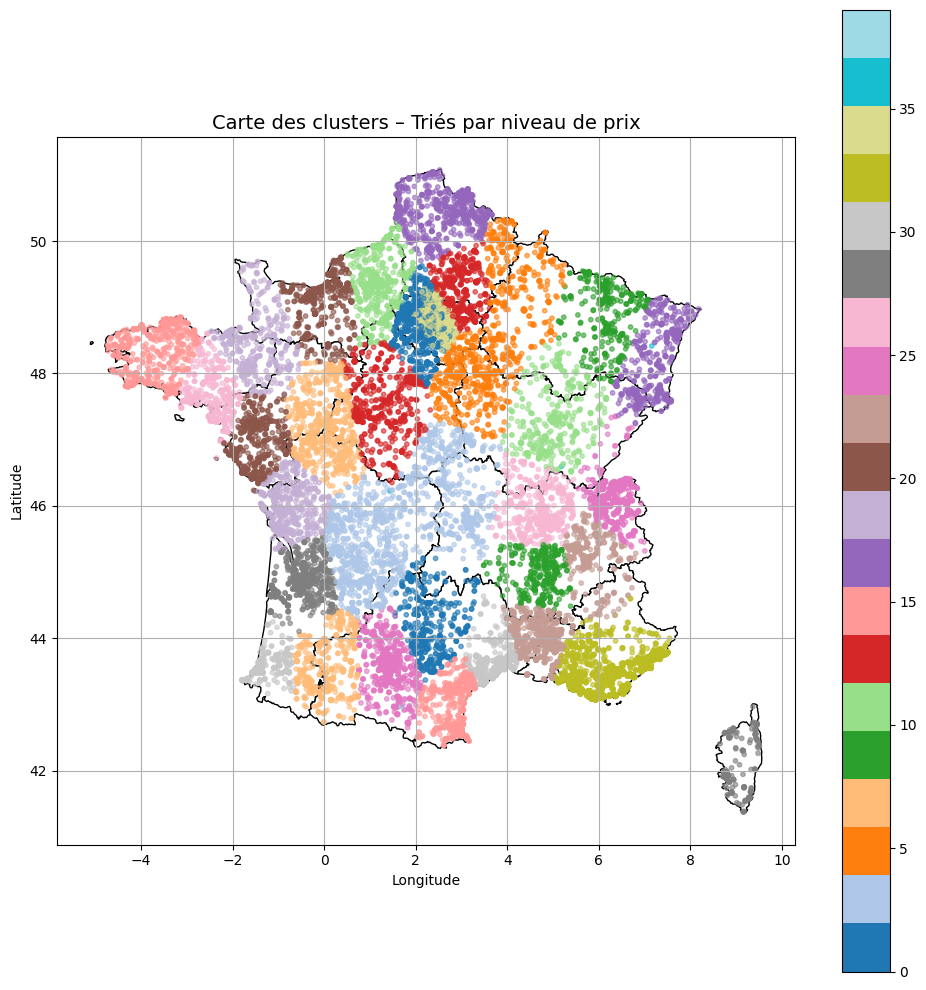

In [ ]:
# on extrait les colonnes qui nous intéressent (latitude, longitude et prix au m2)
#on applique un clustering K-Means avec 40 clusters, chaqque point appartient à un cluster
X_cluster = data_complet[["approximate_latitude", "approximate_longitude", "price_per_m2"]].dropna()
kmeans = KMeans(n_clusters=40, random_state=42)
model = kmeans.fit_predict(X_cluster)
data_complet.loc[X_cluster.index, "geo_price_cluster"] = model #on stocke le numéro de cluster pour chaque point

#on calcule le prix moyen par m2 pour chaque cluster et on trie de manière croissantes
price_rank = data_complet.groupby("geo_price_cluster")["price_per_m2"].mean().sort_values().reset_index()
price_rank["geo_price_rank"] = range(len(price_rank))
data_complet = data_complet.merge(price_rank[["geo_price_cluster", "geo_price_rank"]], on="geo_price_cluster", how="left")

# on crée un dictionnaire qui va associer à chaque cluster son rang
#pour appliquer une échelle de couleur sur la carte
cluster_to_rank = data_complet.groupby("geo_price_cluster")["geo_price_rank"].mean().to_dict()
data_complet["cluster_rank_color"] = data_complet["geo_price_cluster"].map(cluster_to_rank)

#on récupère sur internet une carte de France pour l'affichage
url = "https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/regions-version-simplifiee.geojson"
france = gpd.read_file(url)

# on souhaite créer ici un Geodataframe
#on supprime les données manquantes puis on convertit chaque couple (longitude, latitude) en un objet Point
df_filtered = data_complet.dropna(subset=["approximate_latitude", "approximate_longitude", "cluster_rank_color"])
geometry = [Point(lon, lat) for lon, lat in zip(df_filtered["approximate_longitude"], df_filtered["approximate_latitude"])]
geo_df = gpd.GeoDataFrame(df_filtered, geometry=geometry, crs="EPSG:4326")

# on affiche notre carte
fig, ax = plt.subplots(figsize=(10, 10))
france.plot(ax=ax, color="white", edgecolor="black")
geo_df.plot(ax=ax, column="cluster_rank_color", cmap="tab20", markersize=10, alpha=0.6, legend=True)
ax.set_title("Carte des clusters – Triés par niveau de prix", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()

Dans notre démarche, les données de test ne possédaient pas de cluster initial car elles ne contenaient pas de prix au mètre carré, ce qui empêchait de les inclure directement dans le clustering K-means. Pour leur attribuer tout de même un cluster, on utilise un modèle KNN entraîné uniquement sur les données d’entraînement où les clusters sont connus. Ce modèle KNN, basé sur la proximité géographique (latitude et longitude), permet de prédire le cluster le plus proche pour chaque annonce de test. Ainsi, même sans connaître leur prix, on assigne aux annonces de test un cluster cohérent en se basant sur la localisation, en supposant que des logements proches géographiquement ont des caractéristiques de prix similaires. Cette étape nous donne donc une information précieuse pour notre prédiction finale.

In [ ]:
X_train_knn = X_cluster[["approximate_latitude", "approximate_longitude"]] #contient les coordonnées des biens pour lesquels on a déjà le cluster
y_train_knn = model  # les clusters déjà prédits par KMeans

# on veut affecter aux annonces de tests leur cluster
X_all = data_complet[["approximate_latitude", "approximate_longitude"]].copy() #on récupère les coordonnées
mask_all = X_all.notna().all(axis=1)
X_all_clean = X_all[mask_all]

knn = KNeighborsClassifier(n_neighbors=1) #on entraine un modèle des plus proches voisins à partir des clusters déjà existants
#on crée le classficateur avec un seul voisin, donc on affecte uniquement le plus proche voisin
knn.fit(X_train_knn, y_train_knn)

clusters_pred = knn.predict(X_all_clean)#on fait la prédiction pour les annonces de test
data_complet.loc[X_all_clean.index, "geo_price_cluster"] = clusters_pred #on met les prédictions dans le dataset principal

In [ ]:
#on s'assure que la feature prx au m2 est à jour
data_complet["price_per_m2"] = data_complet["price"] / data_complet["size"]

# on réordonnes les clusters en foncion du prix au m2
price_rank = data_complet.groupby("geo_price_cluster")["price_per_m2"].mean().sort_values().reset_index()
price_rank["geo_price_rank"] = range(len(price_rank))

data_complet = data_complet.merge(price_rank[["geo_price_cluster", "geo_price_rank"]], on="geo_price_cluster", how="left")
data_complet["cluster_rank_color"] = data_complet["geo_price_cluster"].map(price_rank.set_index("geo_price_cluster")["geo_price_rank"])

On affiche la même carte que précédemment mais cette fois-ci avec toutes les annonces

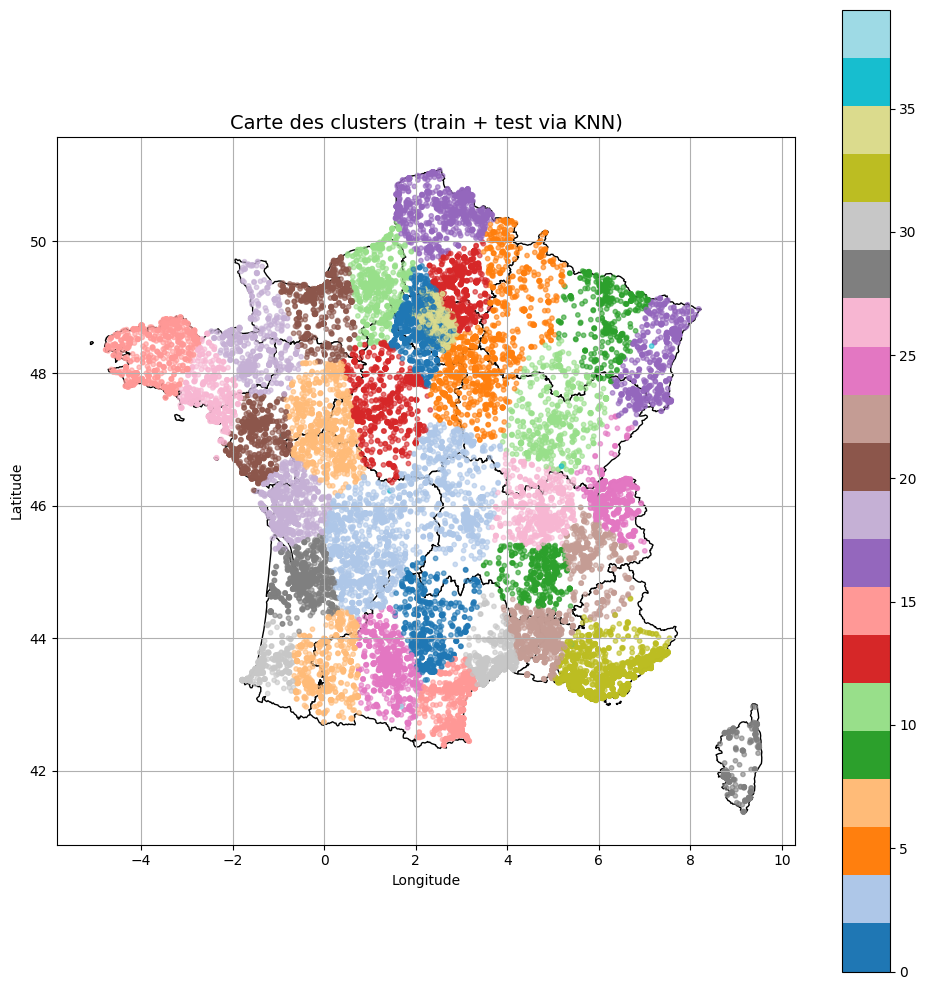

In [ ]:
url = "https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/regions-version-simplifiee.geojson"
france = gpd.read_file(url)


df_filtered = data_complet.dropna(subset=["approximate_latitude", "approximate_longitude", "cluster_rank_color"])
geometry = [Point(lon, lat) for lon, lat in zip(df_filtered["approximate_longitude"], df_filtered["approximate_latitude"])]
geo_df = gpd.GeoDataFrame(df_filtered, geometry=geometry, crs="EPSG:4326")


fig, ax = plt.subplots(figsize=(10, 10))
france.plot(ax=ax, color="white", edgecolor="black")
geo_df.plot(ax=ax, column="cluster_rank_color", cmap="tab20", markersize=10, alpha=0.6, legend=True)
ax.set_title("Carte des clusters (train + test via KNN)", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()

La carte met en évidence plusieurs zones géographiques bien connues du marché immobilier français. Par exemple, Paris et sa région Île-de-France se distinguent par des clusters aux rangs très élevés, reflétant des prix au mètre carré parmi les plus chers du pays. À l’inverse, la « diagonale du vide », qui traverse des régions rurales et peu peuplées apparaît souvent dans des clusters aux rangs faibles, AVEC de prix immobiliers plus bas. On peut aussi observer que la Côte d’Azur se situe dans des clusters à haut rang, illustrant la forte demande et les prix élevés. Ces exemples semble donc nous indiquer que le clustering capture bien les disparités régionales auxquelles nous nous attendions. Il est à noter par contre que les grandes villes riches qui sont intégrées dans un cluster plus larges peuvent nuire à l'interprétabilité.

In [ ]:
# on nettoie notre jeu de données en supprimant la colonne geo_price_rank_x qui était un doublon apparu lors de la fusion de dataframes.
data_complet = data_complet.drop(columns=["geo_price_rank_x"])  #on drop cela car cela on avait un doublon entre x et y
data_complet = data_complet.rename(columns={"geo_price_rank_y": "geo_price_rank"})

In [ ]:
data_train5 = data_complet[data_complet['id_annonce'].isin(id_annonces_train)].copy()
data_train5.columns

Index(['id_annonce', 'approximate_latitude', 'approximate_longitude', 'city',
       'size', 'floor', 'land_size', 'energy_performance_value', 'ghg_value',
       'nb_rooms', 'nb_bedrooms', 'nb_bathrooms', 'nb_parking_places',
       'nb_boxes', 'nb_photos', 'has_a_balcony', 'nb_terraces', 'has_a_cellar',
       'has_a_garage', 'has_air_conditioning', 'last_floor', 'price',
       'city_freq_encode', 'property_type_atelier', 'property_type_chalet',
       'property_type_chambre', 'property_type_château',
       'property_type_divers', 'property_type_duplex', 'property_type_ferme',
       'property_type_gîte', 'property_type_hôtel',
       'property_type_hôtel particulier', 'property_type_loft',
       'property_type_maison', 'property_type_manoir', 'property_type_moulin',
       'property_type_parking', 'property_type_propriété',
       'property_type_péniche', 'property_type_terrain',
       'property_type_terrain à bâtir', 'property_type_viager',
       'property_type_villa', 'exposi

In [ ]:
y = data_train5['log_price']

# 5. Exploitation des images

Ici, on prépare l’enrichissement de notre jeu de données en définissant les chemins vers les dossiers contenant les images des logements, séparément pour les données d’entraînement (path_train_images) et de test (path_test_images). Ces chemins vont nous permettre de charger et d’intégrer les informations visuelles des biens immobiliers dans notre analyse ou modèle.

Cette cellule effectue une opération spécifique dans le pipeline.

In [ ]:
# Chemins d'accès aux images
path_train_images = "/Users/ayrtondossantos/Desktop/STATISTICAL LEARNING/PROJET/reduced_images/train"
path_test_images = "/Users/ayrtondossantos/Desktop/STATISTICAL LEARNING/PROJET/reduced_images/test"


Cette fonction calcule la brillance moyenne des images associées à chaque annonce immobilière dans un dossier donné. Pour chaque identifiant d’annonce, on accède au dossier correspondant contenant plusieurs photos, puis on ouvre chaque image, la redimensionne à une taille standard (70x70 pixels) pour uniformiser le traitement, et la convertit en espace de couleurs HSV. La brillance est extraite du canal V (valeur) qui représente la luminosité de l’image. On calcule ensuite la moyenne de la brillance sur toutes les images de l’annonce afin d’obtenir un indicateur global. Si aucune image n’est trouvée ou en cas d’erreur, on gère cela proprement pour ne pas interrompre le processus. Enfin, la fonction retourne un tableau avec les identifiants des annonces et leur brillance moyenne, prêt à être intégré dans le jeu de données.

In [ ]:
def calculate_brillance_for_dataset(path_folder, annonce_ids):
    results = {'id_annonce': [], 'brillance': []}

    for annonce_id in annonce_ids:
        try:
            folder_path = os.path.join(path_folder, f"ann_{annonce_id}")
            image_files = os.listdir(folder_path)

            brillances = []
            for img_file in image_files:
                img_path = os.path.join(folder_path, img_file)
                img = Image.open(img_path).convert('RGB')   # Charger l'image
                img = img.resize((70, 70))                  # Redimensionner pour standardiser
                img_array = np.asarray(img)
                hsv_image = cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)
                brillance = hsv_image[:,:,2].mean()         # Canal V = valeur = brillance
                brillances.append(brillance)

            if len(brillances) > 0:
                mean_brillance = np.mean(brillances)
            else:
                mean_brillance = np.nan

            results['id_annonce'].append(annonce_id)
            results['brillance'].append(mean_brillance)

        except Exception as e:
            print(f"Erreur pour l'annonce {annonce_id}: {e}")

    return pd.DataFrame(results)

In [ ]:
# Calcul
train_brillance = calculate_brillance_for_dataset(path_train_images, id_annonces_train)
test_brillance = calculate_brillance_for_dataset(path_test_images, id_annonces_test)

# Concaténer les deux
all_brillance = pd.concat([train_brillance, test_brillance], ignore_index=True)

In [ ]:
# Fusion dans le dataset principal
data_complet = data_complet.merge(all_brillance, on="id_annonce", how="left")

# remplacer les valeurs manquantes (annonces sans photo) par la médiane de la brillance
data_complet["brillance"] = data_complet["brillance"].fillna(data_complet["brillance"].median())

Ici, on analyse la relation entre la brillance moyenne des images et le prix des biens immobiliers. Ces coefficients nous indiquent dans quelle mesure la luminosité des images est associée aux variations de prix, ce qui peut aider à comprendre si cette feature influence la valeur perçue des logements.

In [ ]:
df_corr = data_complet[["price", "log_price", "brillance"]].dropna()

# Calcul des corrélations
corr_brillance_price = df_corr["brillance"].corr(df_corr["price"])
corr_brillance_logprice = df_corr["brillance"].corr(df_corr["log_price"])

# Affichage
print(corr_brillance_price)
print(corr_brillance_logprice)

On sauvegarde ici le tableau contenant les valeurs de brillance moyenne pour toutes les annonces dans un fichier CSV. Cela pour éviter d'avoir à relancer le code précédent, souvent long

In [ ]:
# Enregistrer la brillance concaténée dans un fichier CSV
all_brillance.to_csv("brillance_images.csv", index=False)

On charge directement les données depuis un fichier CSV.

In [ ]:
df_brillance = pd.read_csv("brillance_images.csv")

On fusionne les valeurs de brillance calculées pour chaque annonce avec data_complet, la jointure se fait sur la colonne id_annonce,

In [ ]:
data_complet = data_complet.merge(df_brillance, on="id_annonce", how="left")

On fait la même chose que pour la brillance mais cette fois pour l'entropie. Cette fonction calcule l’entropie moyenne des images associées à chaque annonce immobilière, ce qui mesure la complexité de l'information visuelle présente. Plus une image contient de contrastes ou de textures et motifs différents, plus son entropie est élevée.

In [ ]:
def calculate_entropy_for_dataset(path_folder, annonce_ids):
    results = {'id_annonce': [], 'entropy': []}

    for annonce_id in annonce_ids:
        try:
            folder_path = os.path.join(path_folder, f"ann_{annonce_id}")
            image_files = os.listdir(folder_path)

            entropies = []
            for img_file in image_files:
                img_path = os.path.join(folder_path, img_file)
                img = Image.open(img_path).convert('L')  # Niveaux de gris
                img = img.resize((70, 70))               # Redimensionner
                img_array = np.asarray(img)
                entropy = skimage.measure.shannon_entropy(img_array)
                entropies.append(entropy)

            if len(entropies) > 0:
                mean_entropy = np.mean(entropies)
            else:
                mean_entropy = np.nan

            results['id_annonce'].append(annonce_id)
            results['entropy'].append(mean_entropy)

        except Exception as e:
            print(f"Erreur pour l'annonce {annonce_id}: {e}")

    return pd.DataFrame(results)


In [ ]:
# Calcul
train_entropy = calculate_entropy_for_dataset(path_train_images, id_annonces_train)
test_entropy = calculate_entropy_for_dataset(path_test_images, id_annonces_test)

# Concaténer les deux
all_entropy = pd.concat([train_entropy, test_entropy], ignore_index=True)

In [ ]:
# Fusion dans le dataset principal
data_complet = data_complet.merge(all_entropy, on="id_annonce", how="left")

# Option : remplacer les valeurs manquantes (annonces sans photo) par la médiane
data_complet["entropy"] = data_complet["entropy"].fillna(data_complet["entropy"].median())

Ici, on a voulu analyser la corrélation entre l'entropie des images et le prix des biens immobiliers.

In [ ]:
# Filtrer uniquement les lignes avec prix et entropie connus
df_corr = data_complet[["price", "log_price", "entropy"]].dropna()

# Calcul des corrélations (Pearson)
corr_entropy_price = df_corr["entropy"].corr(df_corr["price"])
corr_entropy_logprice = df_corr["entropy"].corr(df_corr["log_price"])

# Affichage
print(corr_entropy_price)
print(corr_entropy_logprice)

On enregsitre une nouvelle fois les résultats dans un fichier csv.

In [ ]:
# Enregistrer l'entropie concaténée dans un fichier CSV
all_entropy.to_csv("entropie_images.csv", index=False)

In [ ]:
df_entropy = pd.read_csv("entropie_images.csv")

In [ ]:
data_complet = data_complet.merge(df_entropy, on="id_annonce", how="left")

Afin d'améliorer nos prédictions, nous avons souhaité prendre en compte l’impact de la proximité des points d’intérêts (POI) sur la valeur des logements. Pour cela, nous devons calculer la distance entre chaque bien immobilier et différents types de POI tels que les écoles, hôpitaux, commerces ou transports. On commence donc par définir un dictionnaire regroupant plusieurs catégories de POI avec leurs sous-types (école, cinéma, pharmacie, etc.). Puis, on utilise une fonction qui récupère ces POI dans une zone géographique donnée en interrogeant la base OpenStreetMap via la bibliothèque OSMnx. Cette fonction extrait les coordonnées géographiques des POI, les convertit en latitude/longitude, filtre pour ne garder que les points valides, et organise le tout dans un dictionnaire. Cela nous permet ensuite de calculer précisément les distances entre les logements et ces différents points, afin d’enrichir notre analyse prédictive des prix immobiliers.

In [ ]:
tags_groupes = {
    "amenity": ["school", "hospital", "cinema", "restaurant", "bar", "pharmacy", "parking"],
    "shop": ["supermarket", "hairdresser"],
    "railway": ["station"]
}

# Fonction pour charger tous les POI d’un type en France (ou une grande zone)

def charger_pois_groupes(place="Île-de-France, France", tags_groupes=tags_groupes):
    df_pois = {}
    for key, valeurs in tags_groupes.items():
        for value in valeurs:
            tag = {key: value}
            try:
                pois = ox.features_from_place(place, tag)
                pois = pois.to_crs(epsg=4326)
                pois = pois[pois.geometry.notnull()]
                pois = pois[pois.geometry.geom_type == "Point"]
                pois["lat"] = pois.geometry.y
                pois["lon"] = pois.geometry.x
                df_pois[value] = pois  # clé = type de POI
            except Exception as e:
                print(f"Erreur pour {value} : {e}")
    return df_pois

On récupère l’ensemble des POI grâce à la fonction définie auparavant, ce qui nous donne un dictionnaire contenant pour chaque type de POI un DataFrame avec leurs emplacements géographiques. On filtre ensuite ce dictionnaire pour ne garder que les entrées valides, c’est-à-dire celles qui sont bien des DataFrames et qui contiennent une colonne “geometry” avec les coordonnées. Enfin, on crée une liste complète des identifiants des annonces, en combinant les identifiants des données d’entraînement et de test, afin de pouvoir calculer la distance entre chaque bien et les POI sélectionnés dans les prochaines étapes.

In [ ]:
#on ne relance pas on a déjà enregistré les résultats

# Récupération de tous les POIs d'un coup
df_pois = charger_pois_groupes()
# Filtrer uniquement les POIs valides (DataFrame avec colonnes geometry)
df_pois_valid = {k: v for k, v in df_pois.items() if isinstance(v, pd.DataFrame) and "geometry" in v.columns}

id_annonces_total = np.concatenate([id_annonces_train, id_annonces_test])

Ce bloc nous permet de calculer la distance au point d’intérêt (POI) le plus proche, en utilisant des informations géographiques (latitude, longitude).  Pour ce faire, le code exploite surtout sklearn.neighbors.BallTree pour effectuer des recherches efficaces de plus proches voisins dans un espace sphérique.

On commence par définir le rayon moyen de la Terre (en mètres), car les distances seront calculées à l’aide de la métrique de Haversine, adaptée aux coordonnées géographiques exprimées en radians. Les coordonnées des biens immobiliers sont donc converties en radians à l’aide de np.radians, car les calculs de distance angulaire reposent sur cette unité.

Ensuite, pour chaque type de POI, on vérifie que les données sont valides (présence des colonnes latitude/longitude), puis on convertit également leurs coordonnées en radians. Si aucun POI n’est disponible pour un type donné, on insère des valeurs NaN pour indiquer l’absence d’information. Sinon, on construit un BallTree à partir des coordonnées des POIs ; cet outil permet une recherche rapide du plus proche voisin pour chaque bien, en tenant compte de la courbure de la Terre via la distance de Haversine. Le résultat de cette recherche est une distance exprimée en radians, que l’on convertit ensuite en mètres en la multipliant par le rayon terrestre. Ce processus est répété pour tous les types de POIs, et les distances minimales sont enregistrées dans une série pour chaque type.

À la fin, toutes ces séries sont concaténées en un DataFrame, avec une colonne supplémentaire identifiant chaque bien (id_annonce). Ce DataFrame est ensuite sauvegardé dans un fichier CSV pour éviter de relancer ce long calcul.

In [ ]:
#on ne relance pas on a déjà enregistré les résultats

# Rayon de la Terre (en mètres)
EARTH_RADIUS = 6371000

# Préparer le tableau de résultats
results = []

# Convertir les lat/lon des biens immobiliers en radians
coords_biens = np.radians(data_complet[["approximate_latitude", "approximate_longitude"]].values)

# Boucle sur chaque type de POI
for poi_type, pois_df in df_pois_valid.items():
    if "lat" not in pois_df.columns or "lon" not in pois_df.columns:
        continue

    # Coordonnées des POIs en radians
    coords_pois = np.radians(pois_df[["lat", "lon"]].values)

    # Si pas de POIs valides, on remplit avec NaN
    if len(coords_pois) == 0:
        min_dists = [np.nan] * len(coords_biens)
    else:
        # Création du BallTree
        tree = BallTree(coords_pois, metric="haversine")

        # Calcul de la distance vers le POI le plus proche (résultat en radians)
        dist_rad, _ = tree.query(coords_biens, k=1)

        # Conversion en mètres
        min_dists = dist_rad.flatten() * EARTH_RADIUS

    # On ajoute au tableau des résultats
    results.append(pd.Series(min_dists, name=poi_type))

# Fusion des résultats
df_geo_features = pd.concat(results, axis=1)
df_geo_features["id_annonce"] = np.concatenate([id_annonces_train, id_annonces_test])

# Sauvegarde locale (évite de relancer le calcul plus tard)
df_geo_features.to_csv("geo_features3.csv", index=False)


On peut directement récupérer les données ici depuis le fichier.

In [ ]:
df_geo_features = pd.read_csv("geo_features3.csv")

data_complet = data_complet.merge(df_geo_features, on="id_annonce", how="left")

Ici, on cherche à enrichir notre jeu de données immobilier avec des informations démographiques, en particulier la population des communes. Cela peut être un facteur explicatif pertinent du prix ou de l'attractivité d’un bien.

On commence par charger un fichier CSV contenant ces données communales.

In [ ]:
# Chargement des données de population
communes_df = pd.read_csv('/Users/ayrtondossantos/Desktop/STATISTICAL LEARNING/donnees_communes.csv', sep=";", encoding="utf-8")  # adapte le chemin et le séparateur

On prépare les données pour pouvoir fusionner les informations de population par commune avec les données immobilières. L’objectif est d’éviter les erreurs liées à des différences d’orthographe, d’accent ou de casse (majuscules/minuscules) dans les noms de villes.

Tout d’abord, on normalise les noms des communes dans le DataFrame communes_df, en convertissant les noms en minuscules (str.lower()) puis en supprimant les accents grâce à unidecode.unidecode. Cela permet d'obtenir une version standardisée des noms, qu’on stocke dans une nouvelle colonne appelée commune_norm. Ensuite, on supprime les doublons éventuels sur cette nouvelle colonne pour s’assurer qu’il n’y a qu’un seul enregistrement par commune.

On garde uniquement les colonnes nécessaires pour la fusion, à savoir commune_norm (le nom standardisé de la commune) et PMUN, qui représente la population municipale. Cette dernière est renommée en population_municipale pour plus de clarté.

Enfin, on applique la même normalisation aux noms de ville du jeu de données immobilier data_complet, en créant une colonne commune_norm basée sur la colonne city, également transformée en minuscules sans accents.

In [ ]:
#on a besoin de la même orthorgraphe pour les villes pour pouvoir insérer les nouvelles données
import unidecode
# Normalisation des noms de commune pour éviter les erreurs d'accent, majuscules, etc.
communes_df['commune_norm'] = communes_df['Commune'].str.lower().apply(unidecode.unidecode)
communes_df = communes_df.drop_duplicates(subset='commune_norm')

# On garde uniquement les colonnes utiles
communes_df = communes_df[['commune_norm', 'PMUN']].rename(columns={'PMUN': 'population_municipale'})

In [ ]:
# Création d'une version normalisée du nom de la ville dans le dataset
data_complet['commune_norm'] = data_complet['city'].str.lower().apply(unidecode.unidecode)

On effectue une jointure (merge) entre data_complet et communes_df via la colonne commune_norm, qui contient les noms de ville normalisés.Ensuite, la colonne commune_norm, utilisée uniquement pour faire la jointure, est supprimée car elle n’est plus nécessaire. On fait ensuite une petite vérification.

In [ ]:
# Jointure sur les noms de commune nettoyés
data_complet = data_complet.merge(communes_df, on='commune_norm', how='left')

# Suppression de la colonne temporaire commune_norm
data_complet.drop(columns='commune_norm', inplace=True)

# Vérification du résultat
print("Lignes avec population :", data_complet['population_municipale'].notna().sum())
print("Lignes avec population manquante :", data_complet['population_municipale'].isna().sum())

Lignes avec population : 38965
Lignes avec population manquante : 7742


In [ ]:
data_complet.shape

(46707, 78)

Ici, on cherche à éviter les valeurs manquantes dans la colonne population_municipale après avoir enrichi notre jeu de données avec la population des communes.  On commence par calculer cette médiane à partir des valeurs disponibles, puis on l’utilise pour remplacer les NaN.

In [ ]:
median_population = data_complet['population_municipale'].median()
data_complet['population_municipale'] = data_complet['population_municipale'].fillna(median_population)

# 6. Random Forest

Dans ce qui suit, nous préparons les données d'entraînement en vue d'entraîner un modèle Random Forest. On extrait les lignes de data_complet correspondant uniquement aux identifiants d'annonces présents dans notre jeu d'entraînement (id_annonces_train). On supprime les colonnes non utiles ou redondantes. On supprime ces colonnes pour ne garder que les features pertinentes avant de finalement vérifie que notre jeu d’entraînement est bien nettoyé.

In [ ]:
data_train3 = data_complet[data_complet['id_annonce'].isin(id_annonces_train)].copy()

# Liste des colonnes à supprimer
colonnes_a_supprimer = ['id_annonce','approximate_latitude','city','approximate_longitude', 'size','price','log_price','land_size','price_per_m2','geo_price_cluster',
       'cluster_rank_color']

data_train3.columns

Index(['id_annonce', 'approximate_latitude', 'approximate_longitude', 'city',
       'size', 'floor', 'land_size', 'energy_performance_value', 'ghg_value',
       'nb_rooms', 'nb_bedrooms', 'nb_bathrooms', 'nb_parking_places',
       'nb_boxes', 'nb_photos', 'has_a_balcony', 'nb_terraces', 'has_a_cellar',
       'has_a_garage', 'has_air_conditioning', 'last_floor', 'price',
       'city_freq_encode', 'property_type_atelier', 'property_type_chalet',
       'property_type_chambre', 'property_type_château',
       'property_type_divers', 'property_type_duplex', 'property_type_ferme',
       'property_type_gîte', 'property_type_hôtel',
       'property_type_hôtel particulier', 'property_type_loft',
       'property_type_maison', 'property_type_manoir', 'property_type_moulin',
       'property_type_parking', 'property_type_propriété',
       'property_type_péniche', 'property_type_terrain',
       'property_type_terrain à bâtir', 'property_type_viager',
       'property_type_villa', 'exposi

In [ ]:
# on supprime les colonnes avant d'entraîner
data_train4 = data_train3.drop(columns=colonnes_a_supprimer)
# on vérifie
print(data_train4.columns)

Index(['floor', 'energy_performance_value', 'ghg_value', 'nb_rooms',
       'nb_bedrooms', 'nb_bathrooms', 'nb_parking_places', 'nb_boxes',
       'nb_photos', 'has_a_balcony', 'nb_terraces', 'has_a_cellar',
       'has_a_garage', 'has_air_conditioning', 'last_floor',
       'city_freq_encode', 'property_type_atelier', 'property_type_chalet',
       'property_type_chambre', 'property_type_château',
       'property_type_divers', 'property_type_duplex', 'property_type_ferme',
       'property_type_gîte', 'property_type_hôtel',
       'property_type_hôtel particulier', 'property_type_loft',
       'property_type_maison', 'property_type_manoir', 'property_type_moulin',
       'property_type_parking', 'property_type_propriété',
       'property_type_péniche', 'property_type_terrain',
       'property_type_terrain à bâtir', 'property_type_viager',
       'property_type_villa', 'exposition_Est-Ouest', 'exposition_Nord',
       'exposition_Nord-Est', 'exposition_Nord-Ouest', 'exposition_Nord-

On sépare les données en jeux d'entraînement et de validation.

In [ ]:
# Séparation des données
X_train, X_val, y_train, y_val = train_test_split(data_train4, y, test_size=0.2, random_state=42)

# Initialisation du modèle Random Forest avec des paramètres choisis à la main
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    random_state=42
)

# Entraînement
rf_model.fit(X_train, y_train)

# Prédictions
y_pred = rf_model.predict(X_val)

# Évaluation
mae = mean_absolute_error(y_val, y_pred)


print("MAE :", mae)

MAE : 0.2963959119020863


# 7. Enrichissement du data

Dans cette partie, notre objectif était d’intégrer une information supplémentaire sur le contexte économique local de chaque bien immobilier, afin d’améliorer la qualité des prédictions de prix. Pour cela, nous avons utilisé les fichiers DVF (Demandes de Valeurs Foncières) disponibles en open data, qui recensent toutes les ventes immobilières réalisées en France. Nous avons sélectionné uniquement les transactions pertinentes, c’est-à-dire les ventes de maisons et d’appartements entre 2020 et 2022, en filtrant les biens pour lesquels la valeur foncière ou la surface bâtie étaient absentes ou incohérentes. Après nettoyage, nous avons calculé le prix au mètre carré pour chaque bien (valeur foncière divisée par la surface bâtie), puis nous avons agrégé ces prix au niveau communal pour obtenir un prix moyen au m² par commune.

Afin de pouvoir rattacher cette nouvelle information à notre dataset principal, nous avons normalisé les noms de commune (en supprimant les majuscules, accents, etc.) dans les deux jeux de données. Une fois les noms harmonisés, nous avons fusionné les deux bases sur cette clé commune. Cela nous a permis d’ajouter une nouvelle variable appelée prix_m2_dvf, qui représente le prix moyen constaté dans la commune du bien. Enfin, pour les biens sans correspondance ou dont la commune était absente dans les DVF, nous avons remplacé les valeurs manquantes par la médiane nationale, afin de ne pas laisser de trou dans les données.

In [ ]:
from unidecode import unidecode

# 1. Définir le chemin et les fichiers DVF
dossier_dvf = "/Users/ayrtondossantos/Desktop/STATISTICAL LEARNING/DVF/"
fichiers_dvf = [
    "ValeursFoncieres-2020.txt",
    "ValeursFoncieres-2021.txt",
    "ValeursFoncieres-2022.txt"
]

# 2. Colonnes à utiliser (tu les as confirmées)
colonnes_utiles = [
    "Commune", "Valeur fonciere", "Surface reelle bati", "Nature mutation", "Type local"
]

# 3. Charger et concaténer les données
dvf_frames = [
    pd.read_csv(dossier_dvf + f, sep="|", usecols=colonnes_utiles, low_memory=False)
    for f in fichiers_dvf
]
df_dvf = pd.concat(dvf_frames, axis=0)

# 4. Nettoyage + conversion
df_dvf = df_dvf[
    (df_dvf["Nature mutation"] == "Vente") &
    (df_dvf["Type local"].isin(["Maison", "Appartement"])) &
    (df_dvf["Valeur fonciere"].notna()) &
    (df_dvf["Surface reelle bati"].notna())
].copy()

# Convertir en float après avoir forcé en string et remplacé les virgules
df_dvf["Valeur fonciere"] = pd.to_numeric(df_dvf["Valeur fonciere"].astype(str).str.replace(',', '.'), errors="coerce")
df_dvf["Surface reelle bati"] = pd.to_numeric(df_dvf["Surface reelle bati"].astype(str).str.replace(',', '.'), errors="coerce")

# On garde uniquement les biens avec une surface > 10m²
df_dvf = df_dvf[df_dvf["Surface reelle bati"] > 10]

# 5. Calcul du prix/m²
df_dvf["price_per_m2"] = df_dvf["Valeur fonciere"] / df_dvf["Surface reelle bati"]

# 6. Normalisation des noms de commune (DVF + data_complet)
df_dvf["commune_norm"] = df_dvf["Commune"].str.lower().apply(unidecode).str.strip()
data_complet["commune_norm"] = data_complet["city"].str.lower().apply(unidecode).str.strip()

# 7. Moyenne du prix au m² par commune
prix_par_commune = df_dvf.groupby("commune_norm")["price_per_m2"].mean().reset_index()
prix_par_commune.columns = ["commune_norm", "prix_m2_dvf"]

# 8. Fusion avec ton dataset principal
data_complet = data_complet.merge(prix_par_commune, on="commune_norm", how="left")
data_complet.drop(columns=["commune_norm"], inplace=True)

# 9. Remplacer les NaN éventuels par la médiane (facultatif mais conseillé)
data_complet["prix_m2_dvf"] = data_complet["prix_m2_dvf"].fillna(data_complet["prix_m2_dvf"].median())

In [ ]:
print(data_complet.columns)

Index(['id_annonce', 'approximate_latitude', 'approximate_longitude', 'city',
       'size', 'floor', 'land_size', 'energy_performance_value', 'ghg_value',
       'nb_rooms', 'nb_bedrooms', 'nb_bathrooms', 'nb_parking_places',
       'nb_boxes', 'nb_photos', 'has_a_balcony', 'nb_terraces', 'has_a_cellar',
       'has_a_garage', 'has_air_conditioning', 'last_floor', 'price',
       'city_freq_encode', 'property_type_atelier', 'property_type_chalet',
       'property_type_chambre', 'property_type_château',
       'property_type_divers', 'property_type_duplex', 'property_type_ferme',
       'property_type_gîte', 'property_type_hôtel',
       'property_type_hôtel particulier', 'property_type_loft',
       'property_type_maison', 'property_type_manoir', 'property_type_moulin',
       'property_type_parking', 'property_type_propriété',
       'property_type_péniche', 'property_type_terrain',
       'property_type_terrain à bâtir', 'property_type_viager',
       'property_type_villa', 'exposi

In [ ]:
data_complet.head

<bound method NDFrame.head of        id_annonce  approximate_latitude  approximate_longitude  \
0        35996577                 43.64                   7.12   
1        35811033                 45.70                   4.90   
2        35731841                 47.97                  -1.22   
3        35886765                 47.29                  -1.88   
4        35781137                 45.72                   4.84   
...           ...                   ...                    ...   
46702    36052217                 43.12                   5.79   
46703    35823719                 43.10                   5.87   
46704    35793053                 45.98                  -1.10   
46705    36049283                 47.28                  -2.20   
46706    35853753                 46.39                  -1.40   

                    city      size  floor  land_size  \
0      villeneuve-loubet     63.00   0.00       0.00   
1             venissieux     90.00   3.00       0.00   
2        

Puis, nous avons cherché à enrichir notre dataset avec une variable socio-économique supplémentaire : le revenu médian par commune, issu des données de l’INSEE. Cette information permet de mieux comprendre le niveau de vie local et, indirectement, le pouvoir d’achat dans la zone où se trouve le bien immobilier. L’hypothèse est que, toutes choses égales par ailleurs, les logements situés dans des communes où les revenus sont plus élevés auront tendance à être plus chers, notamment parce que les acheteurs potentiels y ont plus de capacité financière.

Nous avons commencé par charger un fichier Excel contenant les revenus médians à la commune, puis nettoyé les noms de colonnes pour les rendre exploitables (suppression des espaces, conversion en minuscules). Comme pour les données DVF, il a été nécessaire de normaliser les noms de commune dans les deux fichiers pour pouvoir faire correspondre les enregistrements (mise en minuscule, suppression des accents, etc.). Ensuite, nous avons agrégé les données INSEE par nom de commune au cas où certaines communes apparaîtraient plusieurs fois en calculant la moyenne des revenus médians.

Après cette étape, nous avons fusionné les revenus médians avec notre dataset principal sur la colonne commune_norm. Une fois la variable revenu_median ajoutée, nous avons nettoyé les colonnes intermédiaires, puis remplacé les valeurs manquantes (communes non trouvées dans les données INSEE) par la médiane nationale.

In [ ]:
# 1. Charger le fichier Excel avec les données INSEE
fichier_revenu = "/Users/ayrtondossantos/Desktop/STATISTICAL LEARNING/Niveau_de_vie_2013_a_la_commune-Global_Map_Solution.xlsx"
df_revenu = pd.read_excel(fichier_revenu, sheet_name="Data")

# 2. Nettoyage des noms de colonnes
df_revenu.columns = df_revenu.columns.str.strip().str.lower().str.replace(' ', '_')

# 3. Normaliser les noms de commune dans les deux fichiers
df_revenu["commune_norm"] = df_revenu["nom_commune"].astype(str).str.lower().apply(unidecode).str.strip()
data_complet["commune_norm"] = data_complet["city"].astype(str).str.lower().apply(unidecode).str.strip()

# 4. Agréger les revenus médians par nom de commune (moyenne si plusieurs "Moutiers")
revenu_unique = df_revenu.groupby("commune_norm")["niveau_de_vie_commune"].mean().reset_index()

# 5. Fusion avec le dataset principal
data_complet = data_complet.merge(
    revenu_unique.rename(columns={"niveau_de_vie_commune": "revenu_median"}),
    on="commune_norm",
    how="left"
)

# 6. Nettoyage
data_complet.drop(columns=["commune_norm"], inplace=True)

# 7. Remplacer les valeurs manquantes (NaN) par la médiane nationale
data_complet["revenu_median"] = data_complet["revenu_median"].fillna(data_complet["revenu_median"].median())

# 8. Vérification
print(data_complet[["city", "revenu_median"]].head(10))

                  city  revenu_median
0    villeneuve-loubet      23,598.00
1           venissieux      15,621.00
2             moutiers      19,210.19
3            cordemais      21,156.67
4            lyon-7eme      19,640.00
5       chilly-mazarin      21,790.00
6    neuilly-sur-seine      43,078.89
7    quemper-guezennec      18,538.50
8  canet-en-roussillon      19,387.33
9    locmaria-plouzane      23,634.44


In [ ]:
data_complet.shape

(46707, 80)

Pour mieux capturer l’effet de la localisation d’un bien immobilier sur son prix, nous avons introduit une nouvelle variable géographique : la distance entre le bien et le centre-ville le plus proche parmi les dix plus grandes villes de France. L’idée ici est que, plus un bien est proche d’un centre urbain, plus il a de chances d’être valorisé, que ce soit pour des raisons économiques (emplois) ou pratiques (transports, services publics...). Pour mesurer cela, on a commencé par enregistrer les coordonnées GPS (latitude et longitude) des centres-villes des dix plus grandes villes de France. Ensuite, on a utilisé une fonction mathématique appelée formule de Haversine. Elle permet de calculer la distance « à vol d’oiseau » entre deux points sur la Terre en prenant en compte sa courbure. Cette méthode donne un résultat en kilomètres, plus réaliste qu’une simple différence de coordonnées.

Pour chaque bien, on a calculé la distance à chacune des dix villes, et on a gardé la plus petite distance. On l’a stockée dans une nouvelle variable, appelée distance_centre_ville. Elle permet de capturer de manière assez simple si un bien est plutôt central ou très éloigné d’une ville importante.

In [ ]:
# 1. Coordonnées GPS des centres-villes des 10 plus grandes villes (modifiable)
centres_villes = {
    "paris": (48.8566, 2.3522),
    "marseille": (43.2965, 5.3698),
    "lyon": (45.75, 4.85),
    "toulouse": (43.6045, 1.4442),
    "nice": (43.7009, 7.2683),
    "nantes": (47.2184, -1.5536),
    "montpellier": (43.6111, 3.8767),
    "strasbourg": (48.5734, 7.7521),
    "bordeaux": (44.8378, -0.5792),
    "lille": (50.6292, 3.0573)
}

# 2. Fonction pour calculer la distance en km avec la formule de Haversine
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # rayon de la Terre en km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    d_phi = np.radians(lat2 - lat1)
    d_lambda = np.radians(lon2 - lon1)
    a = np.sin(d_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(d_lambda/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

# 3. Fonction pour chaque bien : distance minimale à un centre-ville connu
def distance_min_centres(row):
    lat, lon = row["approximate_latitude"], row["approximate_longitude"]
    distances = [haversine(lat, lon, lat_c, lon_c) for lat_c, lon_c in centres_villes.values()]
    return min(distances)

# 4. Appliquer au dataset
data_complet["distance_centre_ville"] = data_complet.apply(distance_min_centres, axis=1)

Cette cellule gère les données manquantes en les supprimant ou en les remplaçant.

In [ ]:
# Affiche 10 lignes aléatoires avec la ville et la distance au centre-ville
print(data_complet[["city", "distance_centre_ville"]].dropna().sample(20, random_state=42))

                            city  distance_centre_ville
2865                     arcomps                 213.09
8178                   richelieu                 143.54
25730                   grenoble                  92.50
29901                  perpignan                 128.93
18508  saint-paul-trois-chateaux                 109.59
38418                  ouveillan                  81.23
31239                  pluvigner                 125.30
14006         verneuil-sur-seine                  31.01
19380                   toulouse                   0.51
35376                bois-d'arcy                  25.12
42458                 athis-mons                  15.72
34302                     loudun                 126.27
40655          castillon-du-gard                  67.18
46631                     tavaux                 150.02
1570                        uzes                  62.26
36005                  propriano                 263.30
33803                    vazerac                

# 7. XGBoost

Dans ce qui suit, nous préparons les données d'entraînement en vue d'entraîner un modèle XGBoost. On extrait les lignes de data_complet correspondant uniquement aux identifiants d'annonces présents dans notre jeu d'entraînement (id_annonces_train). On supprime les colonnes non utiles ou redondantes. On supprime ces colonnes pour ne garder que les features pertinentes avant de finalement vérifie que notre jeu d’entraînement est bien nettoyé.

In [ ]:
data_train21 = data_complet[data_complet['id_annonce'].isin(id_annonces_train)].copy()

# Liste des colonnes à supprimer
colonnes_a_supprimer = ['id_annonce','approximate_latitude','city','approximate_longitude', 'size','price','log_price','land_size','price_per_m2','geo_price_cluster',
       'cluster_rank_color']

data_train21.columns

In [ ]:
# on supprime les colonnes avant d'entraîner
data_train22 = data_train21.drop(columns=colonnes_a_supprimer)
# on vérifie
print(data_train22.columns)

Dans cette partie, on cherche à optimiser les performances du modèle XGBoost en trouvant automatiquement les meilleurs hyperparamètres. Pour cela, on utilise une méthode appelée RandomizedSearchCV, qui va tester un grand nombre de combinaisons différentes de paramètres.

On commence par séparer les données d’entraînement en deux parties : 80 % pour entraîner le modèle (X_train, y_train) et 20 % pour valider sa performance (X_val, y_val). Ensuite, on définit un espace de recherche d’hyperparamètres : ce sont toutes les options que l’on laisse XGBoost explorer. Cela inclut des paramètres classiques comme la profondeur des arbres (max_depth), le taux d’apprentissage (learning_rate), ou encore des réglages plus avancés comme la régularisation (reg_alpha, reg_lambda) ou la fraction de données utilisée à chaque arbre (subsample, colsample_bytree…).

On utilise ici une validation croisée à 10 plis (KFold), ce qui permet de tester chaque combinaison de paramètres sur plusieurs sous-ensembles du jeu d’entraînement. La métrique choisie pour juger la performance est la MAE (erreur absolue moyenne).

Finalement, RandomizedSearchCV va exécuter 150 essais différents, chacun correspondant à une combinaison aléatoire de ces paramètres. Le but est de trouver la meilleure configuration possible pour obtenir des prédictions les plus précises sur notre problème de prédiction de prix.

In [ ]:
# Séparation
X_train, X_val, y_train, y_val = train_test_split(data_train22, y, test_size=0.2, random_state=42)

# Définir l'espace des hyperparamètres
param_distributions = {
    'tree_method': ['auto', 'exact'],
    'learning_rate': np.linspace(0.1, 0.4, 10),  # Valeurs entre 0.1 et 0.4
    'max_depth': range(2, 8),                    # 2 à 7 inclus
    'min_child_weight': np.logspace(-3, 1, 10),   # Entre 0.001 et 10 (échelle logarithmique)
    'subsample': np.arange(0.1, 1.05, 0.05),      # 0.1 à 1 par pas de 0.05
    'colsample_bytree': np.arange(0.1, 1.05, 0.05),
    'colsample_bylevel': np.arange(0.1, 1.05, 0.05),
    'gamma': np.logspace(-10, 1, 10),             # Entre 1e-10 et 10
    'reg_lambda': np.logspace(-10, 2, 10),        # Entre 1e-10 et 100
    'reg_alpha': np.logspace(-10, 2, 10),
}

# Créer le modèle XGB vide
xgb_model = XGBRegressor()

# Définir la validation croisée
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Setup du RandomizedSearch
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=150,  # 100 essais différents
    scoring='neg_mean_absolute_error',  # MAE
    cv=kf,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Exécuter la recherche
random_search_xgb.fit(X_train, y_train)

Fitting 10 folds for each of 150 candidates, totalling 1500 fits
[CV] END colsample_bylevel=0.4500000000000001, colsample_bytree=0.9500000000000003, gamma=1e-10, learning_rate=0.23333333333333336, max_depth=7, min_child_weight=0.46415888336127775, reg_alpha=1e-06, reg_lambda=1e-06, subsample=0.40000000000000013, tree_method=exact; total time=   4.1s
[CV] END colsample_bylevel=0.15000000000000002, colsample_bytree=0.8500000000000003, gamma=0.00012915496650148855, learning_rate=0.2666666666666667, max_depth=4, min_child_weight=3.593813663804626, reg_alpha=1e-10, reg_lambda=1e-10, subsample=0.4500000000000001, tree_method=auto; total time=   0.5s
[CV] END colsample_bylevel=0.4500000000000001, colsample_bytree=0.7500000000000002, gamma=0.5994842503189421, learning_rate=0.33333333333333337, max_depth=4, min_child_weight=10.0, reg_alpha=4.641588833612773e-08, reg_lambda=100.0, subsample=0.9000000000000002, tree_method=exact; total time=   2.4s
[CV] END colsample_bylevel=0.3500000000000001, c

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=No...
                                        'reg_lambda': array([1.00000000e-10, 2.15443469e-09, 4.64158883e-08, 1.00000000e-06,
       2.15443469e-05, 4.64158883e-04, 1.00000000e-02, 2.15443469e-01,
       4.64158883e+00, 1.00000000e+02]),
                                        'subsample': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                                        'tree_method': ['auto', 'exact']},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=2)

On affiche les résultats trouvés.

In [ ]:
# Meilleurs paramètres trouvés
print("Best parameters for XGB:")
print(random_search_xgb.best_params_)

# Meilleure performance
print("Best score (MAE):")
print(-random_search_xgb.best_score_)

Best parameters for XGB:
{'tree_method': 'auto', 'subsample': np.float64(1.0000000000000002), 'reg_lambda': np.float64(0.01), 'reg_alpha': np.float64(4.641588833612773e-08), 'min_child_weight': np.float64(0.007742636826811269), 'max_depth': 7, 'learning_rate': np.float64(0.23333333333333336), 'gamma': np.float64(4.641588833612782e-07), 'colsample_bytree': np.float64(0.9000000000000002), 'colsample_bylevel': np.float64(0.6000000000000002)}
Best score (MAE):
0.2581488320452194


Après avoir effectué une première recherche large sur les hyperparamètres du modèle XGBoost, on affine maintenant les réglages autour des valeurs optimales trouvées précédemment. L’objectif est d’améliorer encore les performances du modèle en testant des combinaisons plus précises et concentrées dans les plages prometteuses.

On définit donc des plages étroites autour des meilleurs paramètres identifiés : par exemple, un taux d’apprentissage centré autour de 0.23, une profondeur d’arbre autour de 7, ou encore des coefficients de régularisation (reg_alpha, reg_lambda) autour des meilleures valeurs obtenues.

On relance ensuite une nouvelle recherche aléatoire avec 50 essais différents (n_iter=50), toujours évalués avec la validation croisée à 5 plis et la métrique MAE. Cette étape permet de peaufiner le modèle avec plus de précision, pour tirer le meilleur parti de la structure des données sans tomber dans l’overfitting.

Enfin, on affiche le meilleur score obtenu (en MAE) ainsi que les paramètres optimaux correspondants.

In [ ]:
# Définir les plages étroites autour des meilleurs paramètres
param_distributions_fine = {
    'learning_rate': np.linspace(0.20, 0.30, 5),             # autour de 0.233
    'max_depth': [6, 7, 8],                                  # autour de 7
    'min_child_weight': np.linspace(0.005, 0.015, 5),        # autour de 0.0077
    'gamma': np.linspace(1e-8, 1e-6, 5),                     # autour de 4.6e-7
    'reg_alpha': np.linspace(1e-8, 1e-6, 5),                 # autour de 4.6e-8
    'reg_lambda': np.linspace(0.005, 0.02, 5),               # autour de 0.01
    'subsample': np.linspace(0.95, 1.0, 3),                  # autour de 1.0
    'colsample_bytree': np.linspace(0.85, 0.95, 5),          # autour de 0.9
    'colsample_bylevel': np.linspace(0.55, 0.65, 5),         # autour de 0.6
    'tree_method': ['auto']
}

# Initialiser le modèle
xgb = XGBRegressor(random_state=42)

# Validation croisée
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Recherche affinée
search_fine = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions_fine,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    cv=cv,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Entraînement
search_fine.fit(X_train, y_train)

# Résultat
print("Best score (MAE):", -search_fine.best_score_)
print("Best parameters:", search_fine.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits

[CV] END colsample_bylevel=0.15000000000000002, colsample_bytree=0.1, gamma=0.5994842503189421, learning_rate=0.33333333333333337, max_depth=3, min_child_weight=0.1668100537200059, reg_alpha=1e-06, reg_lambda=0.01, subsample=0.6000000000000002, tree_method=auto; total time=   0.4s
[CV] END colsample_bylevel=0.15000000000000002, colsample_bytree=0.1, gamma=0.5994842503189421, learning_rate=0.33333333333333337, max_depth=3, min_child_weight=0.1668100537200059, reg_alpha=1e-06, reg_lambda=0.01, subsample=0.6000000000000002, tree_method=auto; total time=   0.4s
[CV] END colsample_bylevel=0.8000000000000003, colsample_bytree=0.5000000000000001, gamma=4.641588833612782e-07, learning_rate=0.33333333333333337, max_depth=5, min_child_weight=0.05994842503189409, reg_alpha=4.641588833612772, reg_lambda=4.641588833612773e-08, subsample=0.8500000000000003, tree_method=exact; total time=   4.2s
[CV] END colsample_bylevel=0.70000000000000

On fait encore deux nouvelles recherches pour trouver les meilleurs hyperparamètres.

In [ ]:
# Séparation
X_train, X_val, y_train, y_val = train_test_split(data_train22, y, test_size=0.2, random_state=42)

# Nouvel espace de recherche, plus ciblé et affiné
param_distributions = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': np.linspace(0.1, 0.3, 5),
    'max_depth': [6, 7, 8],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'colsample_bylevel': [0.4, 0.6, 0.8],
    'gamma': [0, 0.05, 0.1, 0.2],
    'reg_alpha': [0, 0.001, 0.01, 0.1],
    'reg_lambda': [0.01, 0.1, 1]
}

xgb_model = XGBRegressor(objective='reg:squarederror', tree_method='hist', random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=100,
    scoring='neg_mean_absolute_error',
    cv=kf,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Meilleurs paramètres :")
print(random_search.best_params_)
print("Meilleure MAE :")
print(-random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits

[CV] END colsample_bylevel=0.5500000000000002, colsample_bytree=0.9000000000000002, gamma=10.0, learning_rate=0.2666666666666667, max_depth=2, min_child_weight=0.001, reg_alpha=0.21544346900318778, reg_lambda=1e-06, subsample=0.1, tree_method=exact; total time=   1.1s
[CV] END colsample_bylevel=0.20000000000000004, colsample_bytree=0.7000000000000002, gamma=2.782559402207126e-08, learning_rate=0.2666666666666667, max_depth=5, min_child_weight=0.001, reg_alpha=2.1544346900318823e-05, reg_lambda=0.00046415888336127724, subsample=0.8000000000000003, tree_method=auto; total time=   0.5s
[CV] END colsample_bylevel=0.5500000000000002, colsample_bytree=0.7000000000000002, gamma=10.0, learning_rate=0.33333333333333337, max_depth=2, min_child_weight=0.021544346900318832, reg_alpha=2.1544346900318823e-05, reg_lambda=100.0, subsample=0.5500000000000002, tree_method=exact; total time=   1.7s
[CV] END colsample_bylevel=0.75000000000000

In [ ]:
# Recherche fine autour des meilleurs paramètres trouvés précédemment (optimisation MSE)

param_distributions_fine = {
    'n_estimators': [350, 400, 450],
    'learning_rate': np.linspace(0.08, 0.12, 5),
    'max_depth': [7, 8],
    'min_child_weight': [1, 2, 3],
    'subsample': np.linspace(0.75, 0.85, 5),
    'colsample_bytree': np.linspace(0.95, 1.0, 4),
    'colsample_bylevel': np.linspace(0.5, 0.7, 5),
    'gamma': [0, 0.01, 0.05],
    'reg_alpha': np.linspace(0.005, 0.02, 4),
    'reg_lambda': [0.5, 1, 1.5]
}

xgb_model_fine = XGBRegressor(objective='reg:squarederror', tree_method='hist', random_state=42)

kf_fine = KFold(n_splits=5, shuffle=True, random_state=42)

random_search_fine = RandomizedSearchCV(
    estimator=xgb_model_fine,
    param_distributions=param_distributions_fine,
    n_iter=100,  # plus long, mais plus précis
    scoring='neg_mean_absolute_error',
    cv=kf_fine,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search_fine.fit(X_train, y_train)

print("Meilleurs paramètres (recherche fine) :")
print(random_search_fine.best_params_)
print("Meilleure MAE :")
print(-random_search_fine.best_score_)

Avant de passer à la phase de prédiction finale, il est nécessaire de préparer correctement le jeu de test. On commence par sélectionner, dans le dataset complet, uniquement les biens immobiliers dont les identifiants (id_annonce) correspondent à ceux du jeu de test. Cela permet d’isoler les observations pour lesquelles on souhaite prédire le prix.

Une fois cette sélection effectuée, on procède à un nettoyage des colonnes. On retire notamment des informations comme l’identifiant de l’annonce, la localisation précise (latitude, longitude, city), le prix réel ou encore des variables intermédiaires comme price_per_m2 ou cluster_rank_color. Ces colonnes ne doivent pas être utilisées par le modèle à cette étape, soit parce qu’elles révèlent directement la cible à prédire, soit parce qu’elles ne sont pas disponibles en situation réelle. Ce nettoyage permet d’obtenir un jeu de test final cohérent et prêt à être utilisé pour la prédiction.

In [ ]:
data_test21 = data_complet[data_complet['id_annonce'].isin(id_annonces_test)].copy()
colonnes_a_supprimer = ['id_annonce','approximate_latitude','city','approximate_longitude', 'size','price','log_price','land_size','price_per_m2', 'geo_price_cluster', 'cluster_rank_color']
# on supprime les colonnes avant d'entraîner
data_test22 = data_test21.drop(columns=colonnes_a_supprimer)

Puis on réalise ici nos prédictions

In [ ]:
xgb_final15 = random_search_fine.best_estimator_

# 2. Prédiction sur les données de test
y_pred_log15 = xgb_final15.predict(data_test22)

# 3. Passage à l'exponentielle pour revenir aux prix réels
y_pred_price15 = np.exp(y_pred_log15)

# 4. Création du DataFrame de soumission
df_submission15 = pd.DataFrame({
    'id_annonce': id_annonces_test,
    'price': y_pred_price15
})

# 5. Sauvegarde en CSV
df_submission15.to_csv("submission_xgboost15.csv", index=False)

# 8. Iterative Imputer

Finalement, nous testons une méthode d’imputation avancée à l’aide de la classe IterativeImputer, proposée dans le module sklearn.experimental. Cette méthode permet de remplacer les valeurs manquantes de manière plus intelligente que les approches classiques comme la moyenne ou la médiane.

Concrètement, nous ciblons les colonnes pour lesquelles des valeurs sont manquantes et qui sont importantes pour notre modélisation : size, nb_rooms, nb_bedrooms, et nb_bathrooms. Ces variables sont regroupées dans un sous-ensemble du dataset principal, afin de traiter uniquement les données concernées.

Le principe de l’imputation itérative est le suivant : chaque variable contenant des valeurs manquantes est modélisée comme une fonction des autres variables. Le processus s’effectue en plusieurs itérations. À chaque tour, un modèle (ici un RandomForestRegressor) est entraîné pour prédire les valeurs manquantes d’une colonne à partir des autres. Une fois les valeurs de cette colonne imputées, on passe à la suivante, et le cycle recommence. Ce procédé est répété jusqu’à convergence ou jusqu’à atteindre un nombre maximal d’itérations fixé (ici, 10).

Nous appliquons cette technique sur une copie du dataset nommée data_complet2, afin de préserver les données originales et de pouvoir comparer les résultats obtenus avec et sans cette imputation avancée. Une fois l’imputation terminée, les colonnes mises à jour sont réinjectées dans la copie du dataset, permettant ainsi de continuer l’analyse avec des données complètes et potentiellement plus fiables.

In [ ]:
# Étape 2 : Sélectionner les colonnes à imputer
colonnes_a_imputer = ['size', 'nb_rooms', 'nb_bedrooms', 'nb_bathrooms']
donnees_a_imputer = data_complet2[colonnes_a_imputer]

# Étape 3 : Appliquer IterativeImputer avec RandomForestRegressor


imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, random_state=0),
                           max_iter=10, random_state=0)

donnees_imputees = imputer.fit_transform(donnees_a_imputer)

# Étape 4 : Remplacer uniquement les colonnes imputées dans data_complet2
data_complet2[colonnes_a_imputer] = donnees_imputees

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Ici, on applique une transformation logarithmique sur certaines colonnes.

Ici, on applique les m^êmes transformations que celles qu'on avait réalisé au début.

In [ ]:
data_complet2["land_size"]= data_complet2["land_size"].fillna(0)#on remplace les NaN par 0

In [ ]:
data_complet2['log_size']=np.log1p(data_complet2['size'])

On crée les mêmes variables que précédemment, sauf outdoor_score qui est toujours la même colonne que dans data_complet, on reprend exactement les mêmes valeurs.

In [ ]:
# indice pour la densité de pièces, on calcule le nombre de pièces par m2
data_complet2["room_density"] = data_complet2["nb_rooms"] / data_complet2["size"]

data_complet2['TotalSize'] = data_complet2['log_size']+data_complet2['land_size']

Puis on effectue des transformations similaires à ce qu'on avait fait initialement pour le reste de nos données.

In [ ]:
colonnes_a_scaler = [
    'land_size',
    'log_size',
    'TotalSize',
]

In [ ]:
scaler = RobustScaler()
data_complet2[colonnes_a_scaler]=scaler.fit_transform(data_complet2[colonnes_a_scaler])
data_complet2[colonnes_a_scaler].describe()

,land_size,log_size,TotalSize
count,"46,707.00","46,707.00","46,707.00"
mean,2.78,0.39,2.77
std,54.55,1.26,54.46
min,0.00,-3.41,-0.01
25%,0.00,-0.37,-0.01
50%,0.00,0.00,0.00
75%,1.00,0.63,0.99
max,"10,479.22",6.83,"10,462.25"


In [ ]:
data_complet.columns

Index(['id_annonce', 'approximate_latitude', 'approximate_longitude', 'city',
       'size', 'floor', 'land_size', 'energy_performance_value', 'ghg_value',
       'nb_rooms', 'nb_bedrooms', 'nb_bathrooms', 'nb_parking_places',
       'nb_boxes', 'nb_photos', 'has_a_balcony', 'nb_terraces', 'has_a_cellar',
       'has_a_garage', 'has_air_conditioning', 'last_floor', 'price',
       'city_freq_encode', 'property_type_atelier', 'property_type_chalet',
       'property_type_chambre', 'property_type_château',
       'property_type_divers', 'property_type_duplex', 'property_type_ferme',
       'property_type_gîte', 'property_type_hôtel',
       'property_type_hôtel particulier', 'property_type_loft',
       'property_type_maison', 'property_type_manoir', 'property_type_moulin',
       'property_type_parking', 'property_type_propriété',
       'property_type_péniche', 'property_type_terrain',
       'property_type_terrain à bâtir', 'property_type_viager',
       'property_type_villa', 'exposi

In [ ]:
data_complet2["energy_performance_value"]= data_complet2["energy_performance_value"].fillna(data_complet2["energy_performance_value"].median())#on remplace les NaN par 0
data_complet2["ghg_value"]= data_complet2["ghg_value"].fillna(data_complet2["ghg_value"].median())#on remplace les NaN par 0
data_complet2 = data_complet2.drop(["energy_performance_category", "ghg_category"],axis=1)

In [ ]:
data_complet2["exposition"]= data_complet2["exposition"].fillna("inconnue")

In [ ]:
col = ["property_type","exposition"]
data_complet2 = pd.get_dummies(data_complet2, columns =col, drop_first=True)#on supprime une colonne de référence avec drop_first

In [ ]:
data_complet2['price_per_m2'] = data_complet2["price"] / data_complet2["size"]

Afin de récupérer toutes les autres variables présentes dans le dataset original data_complet, nous parcourons chacune de ses colonnes et, pour chaque colonne absente de data_complet2, nous la rajoutons.

In [ ]:
# Boucle pour compléter data_complet2 avec les autres colonnes de data_complet
for col in data_complet.columns:
    if col not in data_complet2.columns:
        data_complet2[col] = data_complet[col]

In [ ]:
print(data_complet.columns)
print(data_complet2.columns)

Index(['id_annonce', 'approximate_latitude', 'approximate_longitude', 'city',
       'size', 'floor', 'land_size', 'energy_performance_value', 'ghg_value',
       'nb_rooms', 'nb_bedrooms', 'nb_bathrooms', 'nb_parking_places',
       'nb_boxes', 'nb_photos', 'has_a_balcony', 'nb_terraces', 'has_a_cellar',
       'has_a_garage', 'has_air_conditioning', 'last_floor', 'price',
       'city_freq_encode', 'property_type_atelier', 'property_type_chalet',
       'property_type_chambre', 'property_type_château',
       'property_type_divers', 'property_type_duplex', 'property_type_ferme',
       'property_type_gîte', 'property_type_hôtel',
       'property_type_hôtel particulier', 'property_type_loft',
       'property_type_maison', 'property_type_manoir', 'property_type_moulin',
       'property_type_parking', 'property_type_propriété',
       'property_type_péniche', 'property_type_terrain',
       'property_type_terrain à bâtir', 'property_type_viager',
       'property_type_villa', 'exposi

# 9. XGBoost

On réalise un deuxième XGBoost de la même manière que ce que l'on avait fait mais avec data_complet2 cette fois-ci.

In [ ]:
data_train23 = data_complet2[data_complet2['id_annonce'].isin(id_annonces_train)].copy()

# Liste des colonnes à supprimer
colonnes_a_supprimer = ['id_annonce','postal_code','approximate_latitude','city','approximate_longitude', 'size','price','log_price','land_size','price_per_m2','geo_price_cluster',
       'cluster_rank_color']

In [ ]:
# on supprime les colonnes avant d'entraîner
data_train24 = data_train23.drop(columns=colonnes_a_supprimer)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from xgboost import XGBRegressor
import numpy as np

# Séparation
X_train, X_val, y_train, y_val = train_test_split(data_train24, y, test_size=0.2, random_state=42)

# Définir l'espace des hyperparamètres
param_distributions = {
    'n_estimators': [350, 400, 450],
    'learning_rate': np.linspace(0.13, 0.17, 5),  # autour de 0.15
    'max_depth': [8, 9, 10],  # autour de 9
    'min_child_weight': np.linspace(0.006, 0.009, 4),  # autour de 0.0075
    'subsample': np.linspace(0.95, 1.0, 3),  # autour de 1.0
    'colsample_bytree': np.linspace(0.85, 0.9, 3),  # autour de 0.875
    'colsample_bylevel': np.linspace(0.58, 0.62, 3),  # autour de 0.6
    'gamma': [0.0, 1e-07, 2e-07],  # très petit
    'reg_alpha': [0.0, 1e-07, 1e-06],
    'reg_lambda': np.linspace(0.008, 0.012, 5)  # autour de 0.01
}
# Créer le modèle XGB vide
xgb_model = XGBRegressor()

# Définir la validation croisée
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Setup du RandomizedSearch
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=150,  # 100 essais différents
    scoring='neg_mean_absolute_error',  # MAE
    cv=kf,
    verbose=2,
    random_state=42,
    n_jobs=-1  # Utiliser tous les CPU pour aller plus vite
)

# Exécuter la recherche
random_search_xgb.fit(X_train, y_train)

Fitting 10 folds for each of 150 candidates, totalling 1500 fits

[CV] END colsample_bylevel=0.8, colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=200, reg_alpha=0, reg_lambda=0.01, subsample=0.9; total time=   1.5s
[CV] END colsample_bylevel=0.8, colsample_bytree=0.8, gamma=0.2, learning_rate=0.25, max_depth=8, min_child_weight=7, n_estimators=400, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=   1.3s
[CV] END colsample_bylevel=0.6, colsample_bytree=0.9, gamma=0.2, learning_rate=0.3, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, reg_lambda=0.01, subsample=0.9; total time=   0.8s
[CV] END colsample_bylevel=0.6, colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.9, gamma=0, learning_rate=0.15, max_depth=7, min_child_weight=3, n_estimators=200, reg_al

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



[CV] END colsample_bylevel=0.6499999999999999, colsample_bytree=0.9833333333333333, gamma=0.05, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=450, reg_alpha=0.02, reg_lambda=1, subsample=0.775; total time=   4.3s
[CV] END colsample_bylevel=0.6499999999999999, colsample_bytree=0.95, gamma=0.01, learning_rate=0.12, max_depth=8, min_child_weight=3, n_estimators=350, reg_alpha=0.01, reg_lambda=1, subsample=0.775; total time=   4.4s
[CV] END colsample_bylevel=0.6499999999999999, colsample_bytree=0.95, gamma=0.05, learning_rate=0.1, max_depth=7, min_child_weight=2, n_estimators=400, reg_alpha=0.01, reg_lambda=1, subsample=0.85; total time=   3.8s
[CV] END colsample_bylevel=0.6499999999999999, colsample_bytree=1.0, gamma=0.01, learning_rate=0.12, max_depth=7, min_child_weight=1, n_estimators=400, reg_alpha=0.01, reg_lambda=1, subsample=0.775; total time=   3.9s
[CV] END colsample_bylevel=0.6499999999999999, colsample_bytree=1.0, gamma=0.01, learning_rate=0.11, max_depth=7,

In [ ]:
# Définir les plages étroites autour des meilleurs paramètres
param_distributions_fine = {
    'learning_rate': np.linspace(0.10, 0.16, 5),        # autour de 0.13
    'max_depth': [8, 9, 10],                            # autour de 9
    'min_child_weight': np.linspace(0.005, 0.015, 5),   # autour de 0.008
    'gamma': np.linspace(0, 1e-6, 5),                   # autour de 1e-07
    'reg_alpha': np.linspace(0, 1e-6, 5),               # autour de 1e-07
    'reg_lambda': np.linspace(0.005, 0.02, 5),          # autour de 0.01
    'subsample': np.linspace(0.95, 1.0, 3),             # autour de 1.0
    'colsample_bytree': np.linspace(0.85, 0.95, 3),     # autour de 0.9
    'colsample_bylevel': np.linspace(0.55, 0.65, 3),    # autour de 0.6
    'n_estimators': [400, 450, 500],                    # autour de 450
    'tree_method': ['hist']
}

# Initialiser le modèle
xgb = XGBRegressor(random_state=42)

# Validation croisée
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Recherche affinée
search_fine = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions_fine,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    cv=cv,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Entraînement
search_fine.fit(X_train, y_train)

# Résultat
print("Best score (MAE):", -search_fine.best_score_)
print("Best parameters:", search_fine.best_params_)

In [ ]:
# Séparation
X_train, X_val, y_train, y_val = train_test_split(data_train24, y, test_size=0.2, random_state=42)

# Nouvel espace de recherche, plus ciblé et affiné
param_distributions = {
    'n_estimators': [400, 450, 500],                        # autour de 450
    'learning_rate': np.linspace(0.08, 0.12, 5),            # autour de 0.1
    'max_depth': [8, 9, 10],                                # autour de 9
    'min_child_weight': np.linspace(0.003, 0.007, 5),       # autour de 0.005
    'gamma': np.linspace(5e-7, 2e-6, 5),                    # autour de 1e-6
    'reg_alpha': np.linspace(5e-7, 1e-6, 5),                # autour de 7.5e-7
    'reg_lambda': np.linspace(0.01, 0.02, 5),               # autour de 0.01625
    'subsample': np.linspace(0.9, 1.0, 3),                  # autour de 0.95
    'colsample_bytree': np.linspace(0.8, 0.9, 3),           # autour de 0.85
    'colsample_bylevel': np.linspace(0.55, 0.65, 3),        # autour de 0.6
    'tree_method': ['hist']                                # fixe (meilleur choix pour XGB sur gros volumes)
}

xgb_model = XGBRegressor(objective='reg:squarederror', tree_method='hist', random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    cv=kf,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Meilleurs paramètres :")
print(random_search.best_params_)
print("Meilleure MAE :")
print(-random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END colsample_bylevel=0.55, colsample_bytree=0.8999999999999999, gamma=5e-07, learning_rate=0.115, max_depth=8, min_child_weight=0.009999999999999998, n_estimators=400, reg_alpha=0.0, reg_lambda=0.0125, subsample=1.0, tree_method=hist; total time=  12.4s
[CV] END colsample_bylevel=0.55, colsample_bytree=0.8999999999999999, gamma=5e-07, learning_rate=0.16, max_depth=8, min_child_weight=0.0075, n_estimators=450, reg_alpha=0.0, reg_lambda=0.0125, subsample=0.975, tree_method=hist; total time=  14.5s
[CV] END colsample_bylevel=0.6000000000000001, colsample_bytree=0.8999999999999999, gamma=2.5e-07, learning_rate=0.14500000000000002, max_depth=9, min_child_weight=0.005, n_estimators=500, reg_alpha=1e-06, reg_lambda=0.00875, subsample=0.95, tree_method=hist; total time=  22.7s
[CV] END colsample_bylevel=0.65, colsample_bytree=0.8999999999999999, gamma=7.5e-07, learning_rate=0.1, max_depth=10, min_child_weight=0.00999999999999

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bylevel=0.65, colsample_bytree=0.8999999999999999, gamma=1e-06, learning_rate=0.14500000000000002, max_depth=10, min_child_weight=0.009999999999999998, n_estimators=500, reg_alpha=7.5e-07, reg_lambda=0.01625, subsample=0.975, tree_method=hist; total time=  31.6s
[CV] END colsample_bylevel=0.6000000000000001, colsample_bytree=0.85, gamma=0.0, learning_rate=0.115, max_depth=10, min_child_weight=0.0075, n_estimators=500, reg_alpha=7.5e-07, reg_lambda=0.0125, subsample=1.0, tree_method=hist; total time=  29.4s
[CV] END colsample_bylevel=0.55, colsample_bytree=0.8999999999999999, gamma=2.5e-07, learning_rate=0.13, max_depth=10, min_child_weight=0.005, n_estimators=400, reg_alpha=2.5e-07, reg_lambda=0.00875, subsample=0.95, tree_method=hist; total time=  24.8s
[CV] END colsample_bylevel=0.55, colsample_bytree=0.85, gamma=7.5e-07, learning_rate=0.115, max_depth=8, min_child_weight=0.012499999999999999, n_estimators=500, reg_alpha=1e-06, reg_lambda=0.005, subsample=0.975, tr

In [ ]:
param_distributions_fine = {
    'n_estimators': [400, 450, 500],                          # autour de 450
    'learning_rate': np.linspace(0.06, 0.10, 5),              # autour de 0.08
    'max_depth': [9, 10, 11],                                 # autour de 10
    'min_child_weight': np.linspace(0.002, 0.004, 5),         # autour de 0.003
    'gamma': np.linspace(1e-6, 2e-6, 5),                      # autour de 1.625e-6
    'reg_alpha': np.linspace(4e-7, 6e-7, 5),                  # autour de 5e-7
    'reg_lambda': np.linspace(0.015, 0.025, 5),               # autour de 0.02
    'subsample': np.linspace(0.85, 0.95, 3),                  # autour de 0.9
    'colsample_bytree': np.linspace(0.8, 0.9, 3),             # autour de 0.85
    'colsample_bylevel': np.linspace(0.5, 0.6, 3),            # autour de 0.55
    'tree_method': ['hist']                                   # fixé pour XGB rapide
}

xgb_model_fine = XGBRegressor(objective='reg:squarederror', tree_method='hist', random_state=42)

kf_fine = KFold(n_splits=5, shuffle=True, random_state=42)

random_search_fine = RandomizedSearchCV(
    estimator=xgb_model_fine,
    param_distributions=param_distributions_fine,
    n_iter=100,  # plus long, mais plus précis
    scoring='neg_mean_absolute_error',
    cv=kf_fine,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search_fine.fit(X_train, y_train)

print("Meilleurs paramètres (recherche fine) :")
print(random_search_fine.best_params_)
print("Meilleure MAE :")
print(-random_search_fine.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits

[CV] END colsample_bylevel=0.6000000000000001, colsample_bytree=0.8, gamma=2e-06, learning_rate=0.1, max_depth=9, min_child_weight=0.006, n_estimators=500, reg_alpha=7.5e-07, reg_lambda=0.0175, subsample=0.95, tree_method=hist; total time=  20.2s
[CV] END colsample_bylevel=0.65, colsample_bytree=0.9, gamma=1.2499999999999999e-06, learning_rate=0.1, max_depth=10, min_child_weight=0.005, n_estimators=450, reg_alpha=7.5e-07, reg_lambda=0.0175, subsample=0.95, tree_method=hist; total time=  29.7s
[CV] END colsample_bylevel=0.55, colsample_bytree=0.9, gamma=8.75e-07, learning_rate=0.11, max_depth=10, min_child_weight=0.007, n_estimators=450, reg_alpha=1e-06, reg_lambda=0.015, subsample=0.9, tree_method=hist; total time=  30.3s
[CV] END colsample_bylevel=0.55, colsample_bytree=0.9, gamma=1.6250000000000001e-06, learning_rate=0.12, max_depth=10, min_child_weight=0.005, n_estimators=500, reg_alpha=1e-06, reg_lambda=0.0175, subsampl

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



[CV] END colsample_bylevel=0.6000000000000001, colsample_bytree=0.8, gamma=2e-06, learning_rate=0.1, max_depth=9, min_child_weight=0.006, n_estimators=500, reg_alpha=7.5e-07, reg_lambda=0.0175, subsample=0.95, tree_method=hist; total time=  20.0s
[CV] END colsample_bylevel=0.65, colsample_bytree=0.9, gamma=1.2499999999999999e-06, learning_rate=0.1, max_depth=10, min_child_weight=0.005, n_estimators=450, reg_alpha=7.5e-07, reg_lambda=0.0175, subsample=0.95, tree_method=hist; total time=  29.8s
[CV] END colsample_bylevel=0.55, colsample_bytree=0.9, gamma=8.75e-07, learning_rate=0.11, max_depth=10, min_child_weight=0.007, n_estimators=450, reg_alpha=1e-06, reg_lambda=0.015, subsample=0.9, tree_method=hist; total time=  30.2s
[CV] END colsample_bylevel=0.55, colsample_bytree=0.9, gamma=1.6250000000000001e-06, learning_rate=0.12, max_depth=10, min_child_weight=0.005, n_estimators=500, reg_alpha=1e-06, reg_lambda=0.0175, subsample=1.0, tree_method=hist; total time=  29.8s
[CV] END colsample

In [ ]:
data_test23 = data_complet2[data_complet2['id_annonce'].isin(id_annonces_test)].copy()
colonnes_a_supprimer = ['id_annonce','postal_code','approximate_latitude','city','approximate_longitude', 'size','price','log_price','land_size','price_per_m2', 'geo_price_cluster', 'cluster_rank_color']
# on supprime les colonnes avant d'entraîner
data_test24 = data_test23.drop(columns=colonnes_a_supprimer)

In [ ]:
xgb_final16 = random_search_fine.best_estimator_

# 2. Prédiction sur les données de test
y_pred_log16 = xgb_final16.predict(data_test24)

# 3. Passage à l'exponentielle pour revenir aux prix réels
y_pred_price16 = np.exp(y_pred_log16)

# 4. Création du DataFrame de soumission
df_submission16 = pd.DataFrame({
    'id_annonce': id_annonces_test,
    'price': y_pred_price16
})

# 5. Sauvegarde en CSV
df_submission16.to_csv("submission_xgboost16.csv", index=False)

[CV] END colsample_bylevel=0.6, colsample_bytree=0.8, gamma=1.5e-06, learning_rate=0.1, max_depth=11, min_child_weight=0.002, n_estimators=450, reg_alpha=4e-07, reg_lambda=0.025, subsample=0.95, tree_method=hist; total time=  34.4s
[CV] END colsample_bylevel=0.55, colsample_bytree=0.8, gamma=2e-06, learning_rate=0.09, max_depth=9, min_child_weight=0.003, n_estimators=400, reg_alpha=5e-07, reg_lambda=0.02, subsample=0.85, tree_method=hist; total time=  16.3s
[CV] END colsample_bylevel=0.6, colsample_bytree=0.8, gamma=1.75e-06, learning_rate=0.08, max_depth=11, min_child_weight=0.002, n_estimators=400, reg_alpha=4.5e-07, reg_lambda=0.0175, subsample=0.8999999999999999, tree_method=hist; total time=  31.1s
[CV] END colsample_bylevel=0.55, colsample_bytree=0.8, gamma=1.75e-06, learning_rate=0.1, max_depth=10, min_child_weight=0.003, n_estimators=500, reg_alpha=5.5e-07, reg_lambda=0.0225, subsample=0.8999999999999999, tree_method=hist; total time=  27.4s
[CV] END colsample_bylevel=0.6, cols

Bien que ce deuxième essai avec Iterative Imputer repose sur une méthode plus sophistiquée, les résultats obtenus sur les performances du modèle n’ont pas montré d’amélioration significative.

# 10. XGBoost et MAPE

Dans ce dernier bloc de code, nous réessayons une modélisation avec XGBoost avec data_complet initial, mais cette fois-ci en utilisant comme métrique d’évaluation le MAPE (Mean Absolute Percentage Error). Contrairement à la MAE qui donne une erreur absolue en valeur monétaire (par exemple en euros), le MAPE exprime l’erreur en pourcentage relatif par rapport à la valeur réelle. Cela peut être particulièrement pertinent dans notre contexte, car le prix des biens immobiliers varie énormément d’un bien à l’autre. Le MAPE permet donc de standardiser l’erreur et de mieux évaluer la performance du modèle sur des biens très différents.

Nous restons sur la même méthode de RandomizedSearchCV, avec une grille resserrée autour des meilleurs hyperparamètres identifiés précédemment, mais cette fois en cherchant à minimiser le MAPE.

In [ ]:
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
import numpy as np

# Séparation des données
X_train, X_val, y_train, y_val = train_test_split(data_train24, y, test_size=0.2, random_state=42)

# Définir le scorer personnalisé basé sur MAPE (positif pour l'optimisation)
def custom_mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

mape_scorer = make_scorer(custom_mape, greater_is_better=False)  # On met False car c'est une erreur à minimiser

# Espace des hyperparamètres
param_distributions_fine = {
    'n_estimators': [400, 450, 500],                          # autour de 450
    'learning_rate': np.linspace(0.06, 0.10, 5),              # autour de 0.08
    'max_depth': [9, 10, 11],                                 # autour de 10
    'min_child_weight': np.linspace(0.002, 0.004, 5),         # autour de 0.003
    'gamma': np.linspace(1e-6, 2e-6, 5),                      # autour de 1.625e-6
    'reg_alpha': np.linspace(4e-7, 6e-7, 5),                  # autour de 5e-7
    'reg_lambda': np.linspace(0.015, 0.025, 5),               # autour de 0.02
    'subsample': np.linspace(0.85, 0.95, 3),                  # autour de 0.9
    'colsample_bytree': np.linspace(0.8, 0.9, 3),             # autour de 0.85
    'colsample_bylevel': np.linspace(0.5, 0.6, 3),            # autour de 0.55
    'tree_method': ['hist']                                   # fixé pour XGB rapide
}

# Création du modèle
xgb_model = XGBRegressor()

# Définition de la validation croisée
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# RandomizedSearchCV avec MAPE
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions_fine,
    n_iter=150,
    scoring=mape_scorer,
    cv=kf,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Entraînement
random_search_xgb.fit(X_train, y_train)

In [ ]:
print("Meilleurs paramètres :")
print(random_search_xgb.best_params_)
print("Meilleure MAPE :")
print(-random_search_xgb.best_score_)

# 11. Figures pour le rapport

In [ ]:
from xgboost import plot_importance

# Génération du graphique
fig, ax = plt.subplots(figsize=(10, 6))
plot_importance(random_search_fine.best_estimator_,
                max_num_features=10,
                importance_type='gain',
                ax=ax)
plt.title("Top 10 des variables les plus importantes (XGBoost optimisé)")
plt.tight_layout()


plt.savefig("feature_importance_xgboost.pdf")
plt.savefig("feature_importance_xgboost.png", dpi=300)
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error


models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "RandomForestRegressor": RandomForestRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "SVR": SVR(),
    "XGBRegressor": XGBRegressor()
}

classifier_score = []

for name, model in models.items():
    print(name)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv = cross_val_score(model, data_train22, y, cv=kfold, scoring="neg_mean_absolute_percentage_error", verbose=2)
    classifier_score.append(cv.mean())
classifier_df = pd.DataFrame({'classifier': models.keys(), 'score': classifier_score})

In [ ]:
classifier_df.sort_values(by='score', ascending=False)

In [ ]:
models = ['Régression linéaire', 'Random Forest', 'XGBoost (avant tuning)', 'XGBoost (après tuning)']
mae_scores = [0.5252, 0.2964, 0.2575, 0.2287]

plt.figure(figsize=(8, 5))
bars = plt.barh(models, mae_scores, color='skyblue')
plt.xlabel('MAE')
plt.title("Comparaison des performances (MAE)")
plt.gca().invert_yaxis()

# Affichage des valeurs
for bar in bars:
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.3f}", va='center')

plt.tight_layout()
plt.savefig("mae_comparaison.png")